# Importar Librerias

In [94]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder
from pandasql import sqldf
import warnings
from itertools import combinations #Generar combinacion de variables
from optbinning import OptimalBinning
from sklearn.model_selection import StratifiedKFold, cross_val_score


warnings.filterwarnings("ignore")

# Importar datos

In [95]:
df = pd.read_excel("Tabla Trabajo Grupal N°2.xlsx", sheet_name= "Desarrollo")

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12356 entries, 0 to 12355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id_Cliente             12356 non-null  int64  
 1   Edad                   12356 non-null  int64  
 2   Nivel_Educacional      12356 non-null  object 
 3   Años_Trabajando        12356 non-null  int64  
 4   Ingresos               12356 non-null  int64  
 5   Deuda_Comercial        12356 non-null  float64
 6   Deuda_Credito          12356 non-null  float64
 7   Otras_Deudas           12356 non-null  float64
 8   Ratio_Ingresos_Deudas  12356 non-null  float64
 9   Default                12356 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 965.4+ KB


In [97]:
df.isnull().sum() #Confirmo que no tiene nulos

Id_Cliente               0
Edad                     0
Nivel_Educacional        0
Años_Trabajando          0
Ingresos                 0
Deuda_Comercial          0
Deuda_Credito            0
Otras_Deudas             0
Ratio_Ingresos_Deudas    0
Default                  0
dtype: int64

El grafico anterior más la tabla nos confirmen quen o existen valores nulos

In [98]:
df.shape #Data con 12.356 registros

(12356, 10)

In [99]:
df.nunique() #Id demuestra que la data no tiene registros repetidos

Id_Cliente               12356
Edad                        60
Nivel_Educacional            5
Años_Trabajando             49
Ingresos                   207
Deuda_Comercial            273
Deuda_Credito              498
Otras_Deudas               703
Ratio_Ingresos_Deudas      135
Default                      2
dtype: int64

In [100]:
df["Default"].value_counts()

Default
1    7819
0    4537
Name: count, dtype: int64

Al tener los mismos ID distintos versus el total de registros nos muestra que no hay registros duplicados  
Además vemos que Nivel educacional es la unica variable realmente categorica además de Default

In [101]:
df.head()

,Id_Cliente,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
0,1,34,SupInc,11,68,11.9,3.37,4.73,0.29,1
1,2,43,Med,3,53,9.8,1.51,3.69,0.28,0
2,3,36,SupInc,7,118,11.2,8.48,4.73,0.21,0
3,4,46,Bas,11,61,10.4,3.44,2.90,0.27,1
4,5,29,Med,0,21,12.4,0.38,2.22,0.71,0


In [102]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], df["Default"],
                                                    train_size= 0.7,
                                                    random_state = 7)

df_train = pd.concat([x_train, y_train], axis = 1)
df_test = pd.concat([x_test, y_test], axis = 1)

In [103]:
df_test

,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
2933,38,SupInc,9,66,5.5,0.57,3.06,0.14,0
601,28,SupCom,2,22,6.2,0.76,0.61,0.34,0
7788,19,Bas,0,20,11.7,1.17,1.17,0.70,0
6455,42,SupInc,19,24,15.1,2.00,1.62,0.78,1
6190,21,SupInc,0,18,12.1,0.59,1.59,0.79,1
...,...,...,...,...,...,...,...,...,...
10366,54,Med,2,32,6.7,0.17,1.97,0.28,1
2094,40,Med,6,36,6.6,1.58,0.80,0.25,0
4347,18,Med,0,18,10.0,1.12,0.68,0.66,0
2423,32,SupInc,10,38,11.5,1.05,3.32,0.42,1


# Analisis descriptivo

## Analisis variables

In [104]:
def graficar_histograma(df, variable):
    plt.figure(figsize = (7,4))
    sns.histplot(df, x = variable)
    plt.title(f"{variable}")
    plt.xlabel(f"{variable}")
    plt.ylabel("Cantidad")

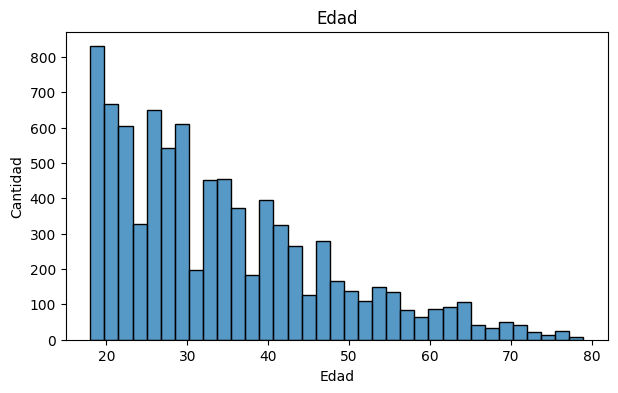

In [105]:
graficar_histograma(df_train, df_train.columns[0])

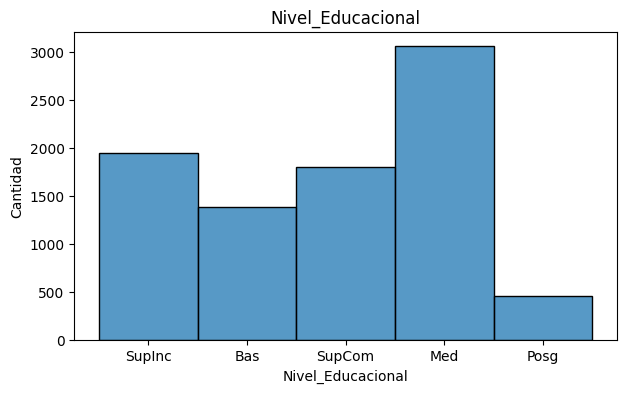

In [106]:
graficar_histograma(df_train, df_train.columns[1])

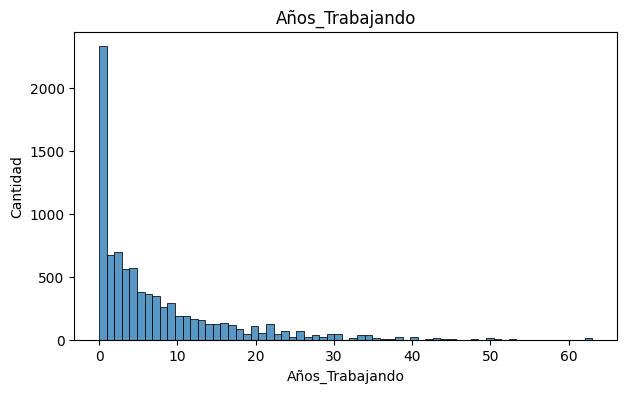

In [107]:
graficar_histograma(df_train, df_train.columns[2])

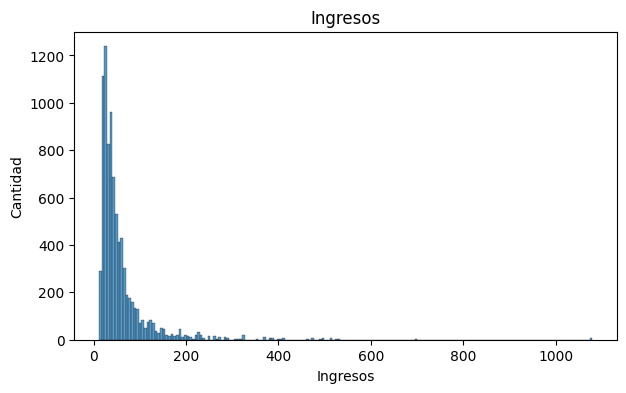

In [108]:
graficar_histograma(df_train, df_train.columns[3])

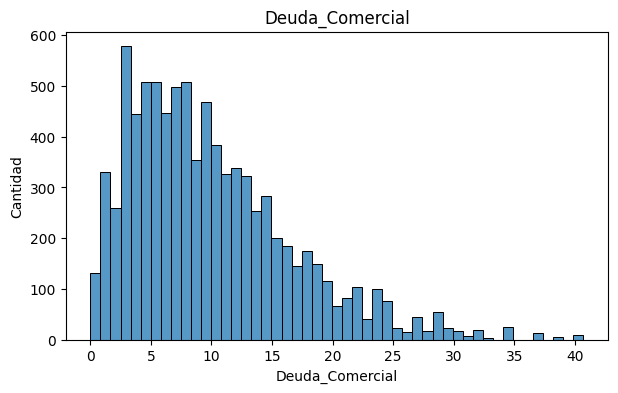

In [109]:
graficar_histograma(df_train, df_train.columns[4])

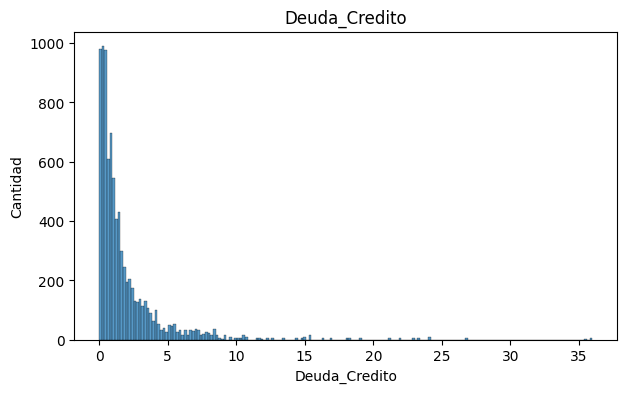

In [110]:
graficar_histograma(df_train, df_train.columns[5])

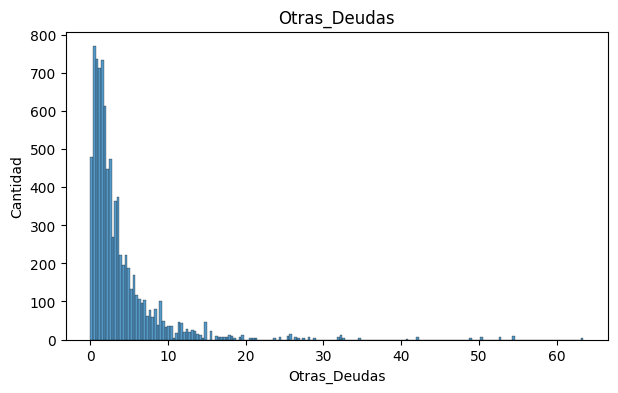

In [111]:
graficar_histograma(df_train, df_train.columns[6])

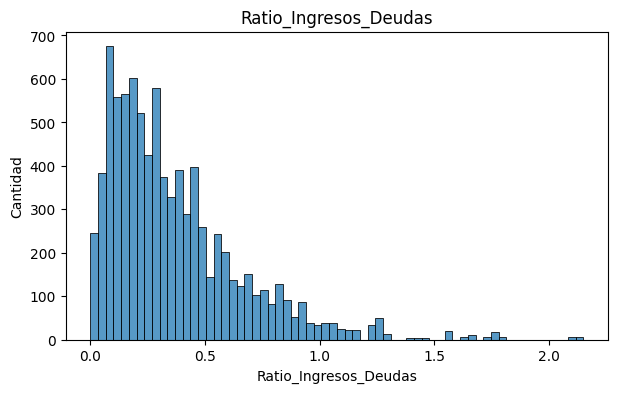

In [112]:
graficar_histograma(df_train, df_train.columns[7])

Text(0.5, 1.0, 'Matriz de correlacion de variables numericas')

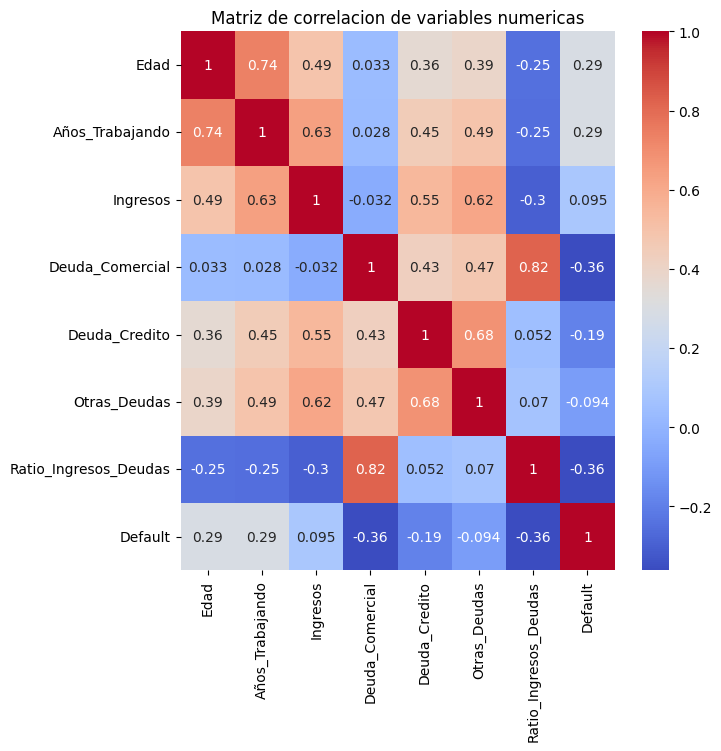

In [113]:
plt.figure(figsize = (7,7))
sns.heatmap(df_train.select_dtypes(include=['number']).corr(), annot= True, cmap = "coolwarm")
plt.title("Matriz de correlacion de variables numericas")

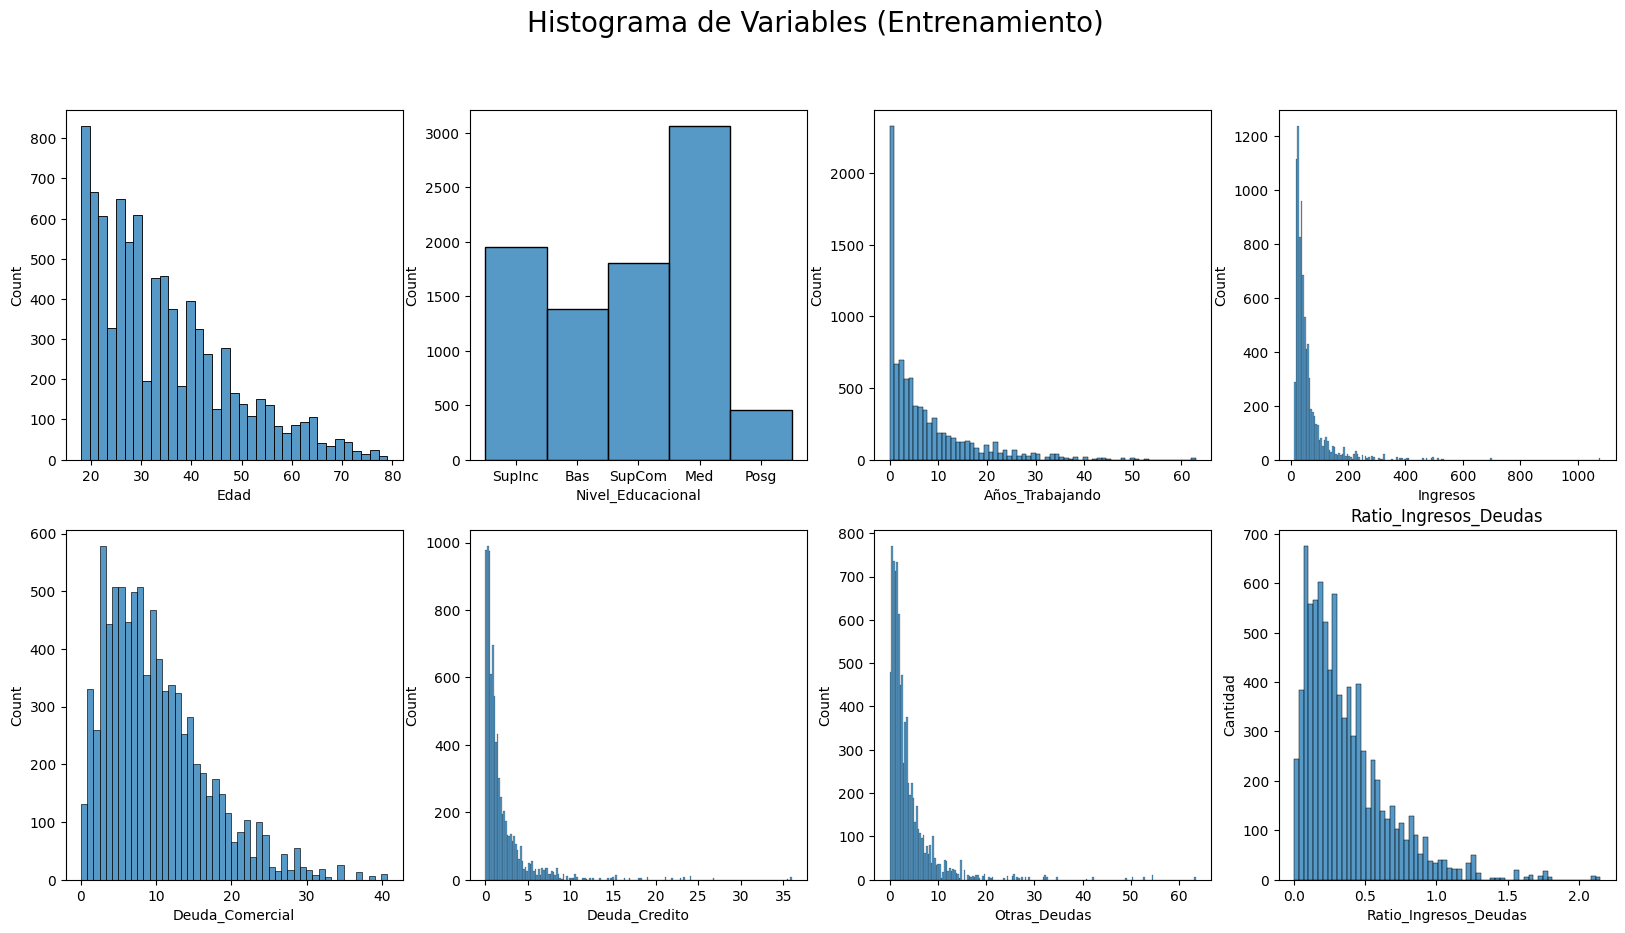

In [114]:
def graficar_histograma_subplots(df, variable, ax ):
    sns.histplot(df, x = variable, ax = ax)
    plt.title(f"{variable}")
    plt.xlabel(f"{variable}")
    plt.ylabel("Cantidad")

fig, axes = plt.subplots(2,4, figsize = (20,10))
axes = axes.flatten()
for ax, var in zip(axes, df_train.columns):
    graficar_histograma_subplots(df_train, var, ax=ax)

fig.suptitle("Histograma de Variables (Entrenamiento)", fontsize=20)
plt.show()

## Analisis variables vs objetivo

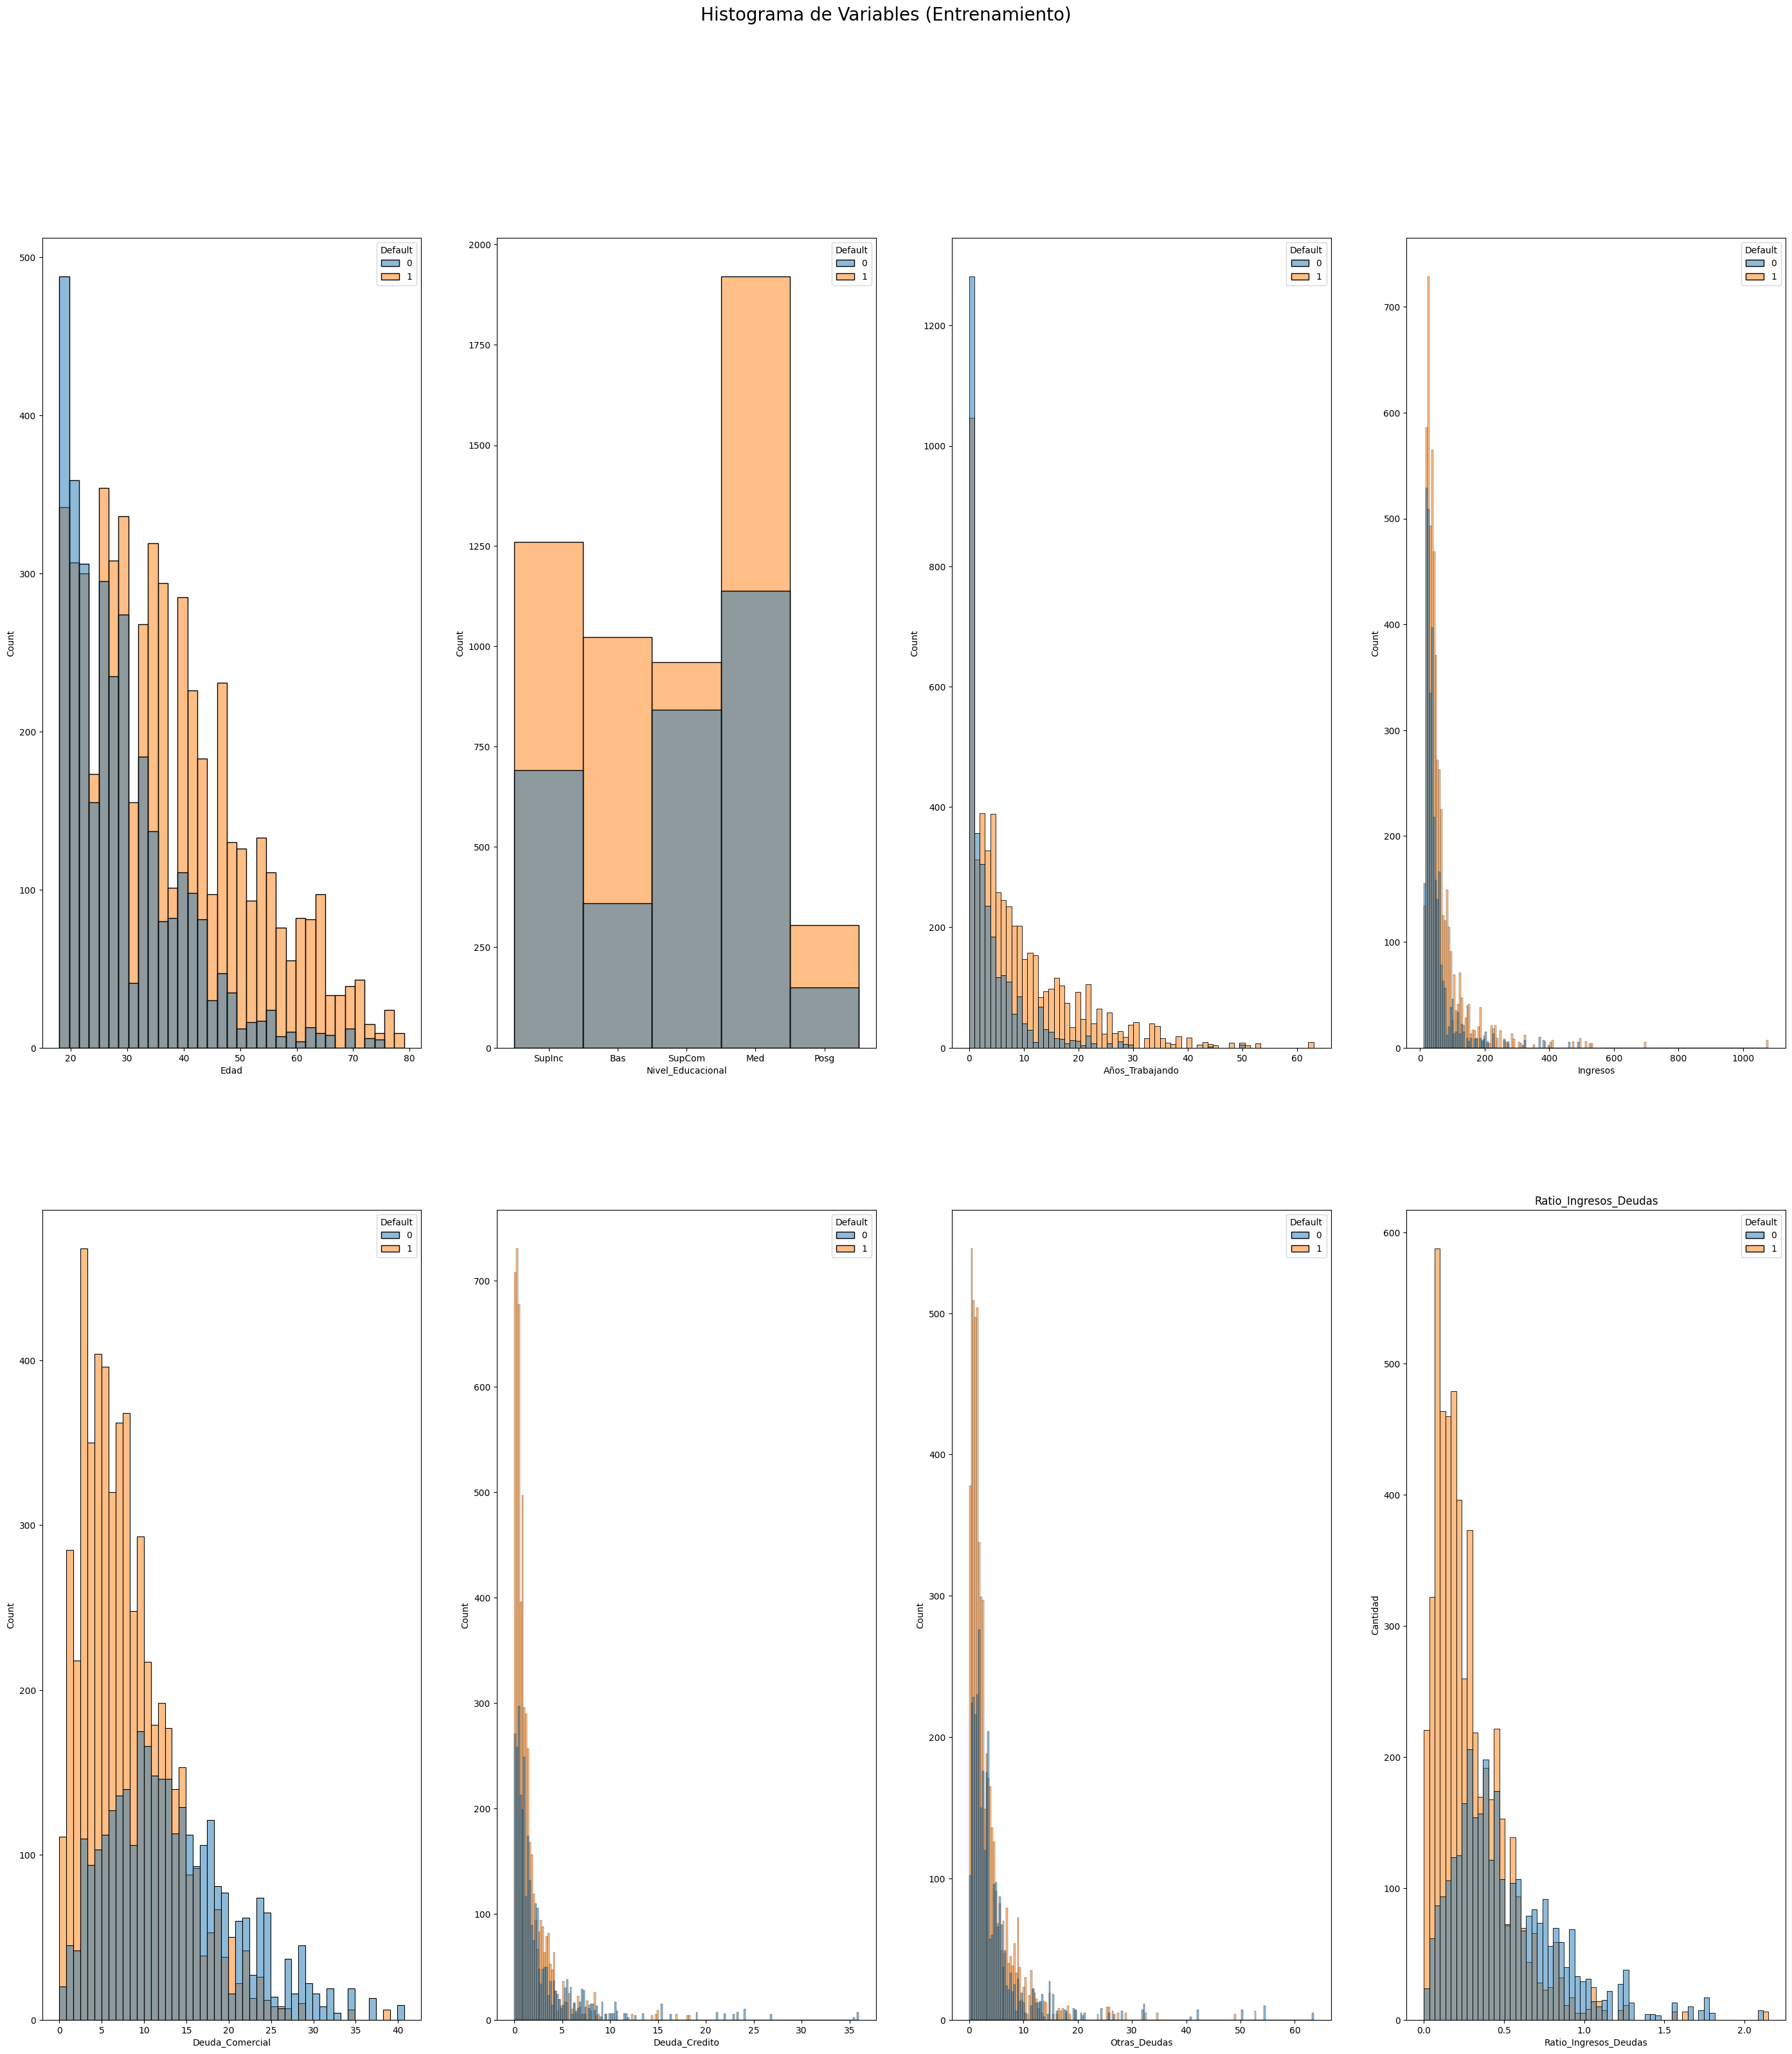

In [115]:
def graficar_histograma_subplots(df, variable, ax ):
    sns.histplot(df, x = variable, hue = "Default" , ax = ax)
    plt.title(f"{variable}")
    plt.xlabel(f"{variable}")
    plt.ylabel("Cantidad")

fig, axes = plt.subplots(2,4, figsize = (35,36))
axes = axes.flatten()
for ax, var in zip(axes, df_train.columns):
    graficar_histograma_subplots(df_train, var, ax=ax)

fig.suptitle("Histograma de Variables (Entrenamiento)", fontsize=20)
plt.show()

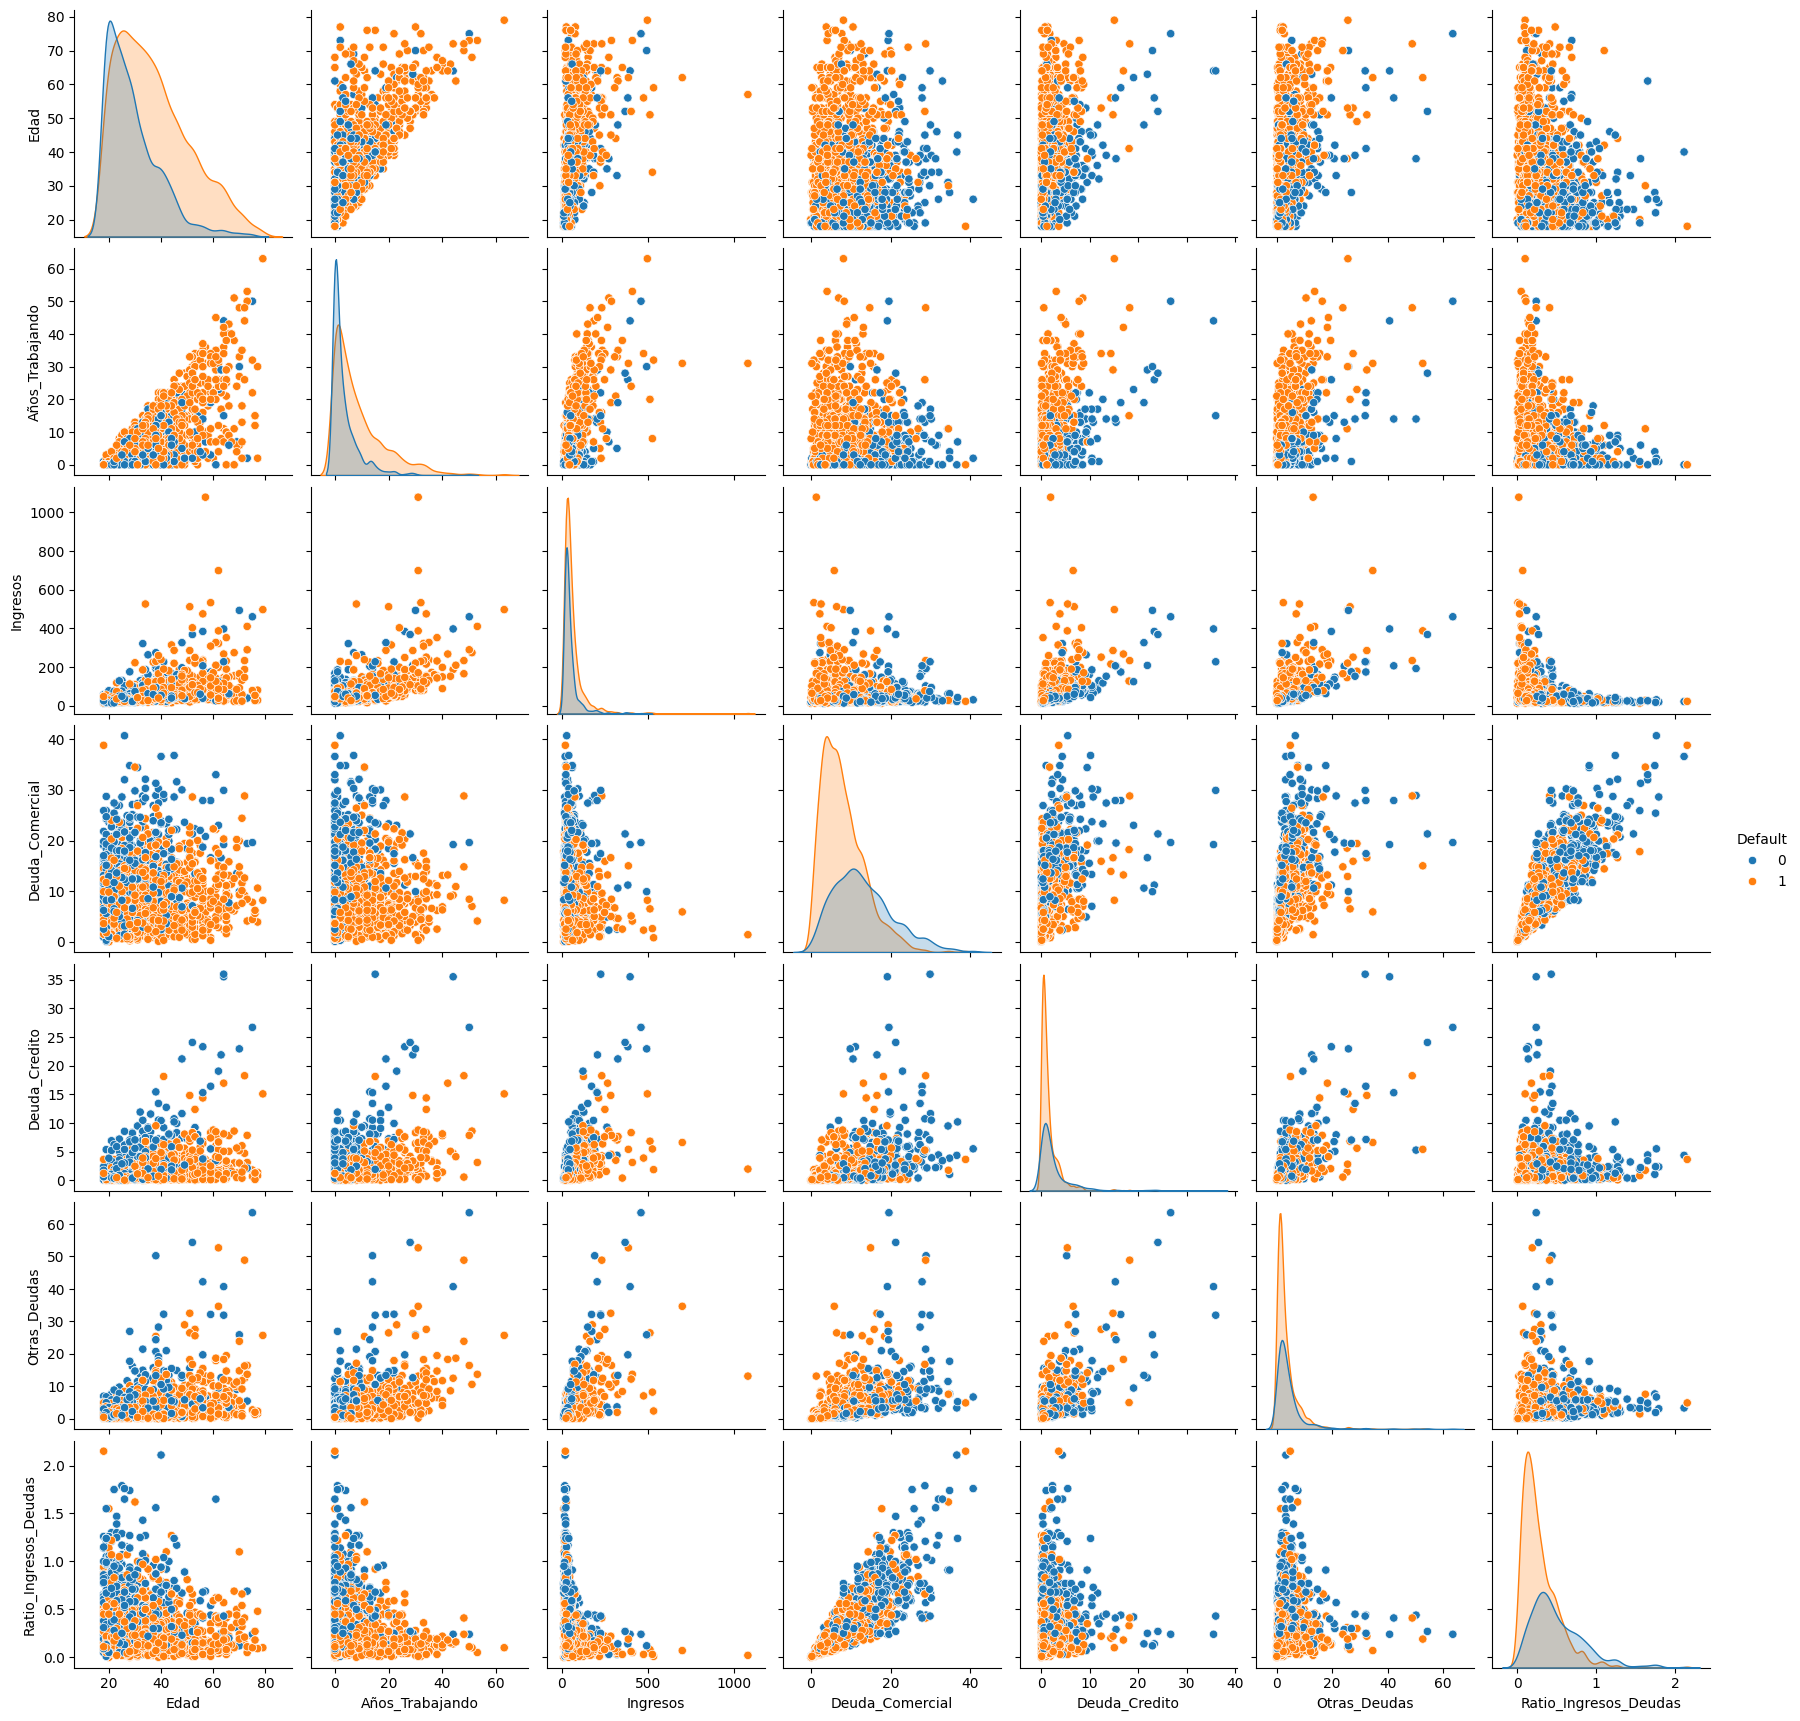

In [116]:
sns.pairplot(df_train, hue = "Default")

#  Modelado Exploratorio

## Modelo Base - Sin agregados

### Simple

In [117]:
df_train_backup = df_train.copy()

In [118]:
df_train["Nivel_Educacional"].nunique

<bound method IndexOpsMixin.nunique of 8694     SupInc
10199       Bas
11129       Bas
9727     SupInc
8294     SupCom
          ...  
4307        Med
5699        Med
10742    SupInc
537         Med
9412        Med
Name: Nivel_Educacional, Length: 8649, dtype: object>

In [119]:
df_train= pd.get_dummies(df_train, "Nivel_Educacional", drop_first= True)
df_test =pd.get_dummies(df_test, "Nivel_Educacional", drop_first= True)

In [120]:
df_train.head()

,Edad,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default,Nivel_Educacional_Med,Nivel_Educacional_Posg,Nivel_Educacional_SupCom,Nivel_Educacional_SupInc
8694,20,0,23,1.0,0.02,0.21,0.05,1,False,False,False,True
10199,22,1,22,3.2,0.16,0.55,0.18,1,False,False,False,False
11129,67,40,88,6.3,1.42,4.12,0.13,1,False,False,False,False
9727,26,2,21,8.2,0.54,1.18,0.47,1,False,False,False,True
8294,22,0,36,3.3,0.28,0.91,0.12,1,False,False,True,False


In [121]:
variables = [col for col in df_train.columns if col not in ["Default"]]

In [122]:
x_train = df_train[variables]
y_terain = df_train["Default"]
x_test = df_test[variables]
y_test = df_test["Default"]

In [123]:
RL = LogisticRegression()

RL.fit(x_train, y_train)
y_predic = RL.predict(x_test)

acc = accuracy_score(y_test, y_predic)
print("El accuracy del modelo es")
print(f"El Accuracy del modelo es {acc:.3f}")


coef = RL.coef_[0]
intercepto = RL.intercept_[0]

df_coef = pd.DataFrame({
    "Variable": variables,
    "Coeficiente": coef
})

print("Intercepto:", intercepto)
print(df_coef)


El accuracy del modelo es
El Accuracy del modelo es 0.772
Intercepto: 0.20800669364214142
                    Variable  Coeficiente
0                       Edad     0.033665
1            Años_Trabajando     0.222103
2                   Ingresos     0.001353
3            Deuda_Comercial    -0.088428
4              Deuda_Credito    -0.494763
5               Otras_Deudas    -0.033599
6      Ratio_Ingresos_Deudas    -0.200753
7      Nivel_Educacional_Med     0.059970
8     Nivel_Educacional_Posg     0.505595
9   Nivel_Educacional_SupCom    -0.134646
10  Nivel_Educacional_SupInc     0.267285


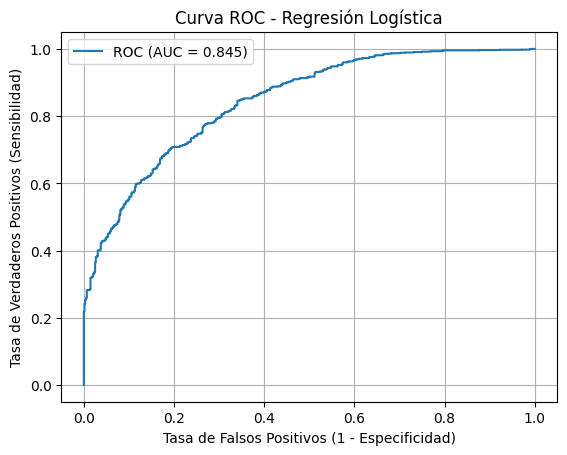

In [124]:
y_scores = RL.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.grid(True)
plt.show()


In [125]:

thresholds = np.arange(0, 1.01, 0.01)   # thresholds de 0.00 a 1.00
accuracies = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_t))

best_t = thresholds[np.argmax(accuracies)]
best_acc = max(accuracies)

print(f"Mejor threshold = {best_t:.2f}")
print(f"Accuracy máximo = {best_acc:.4f}")

Mejor threshold = 0.51
Accuracy máximo = 0.7769


### Stepwise

In [126]:
y_test.shape

(3707,)

In [127]:
def modelo_stepwise(x_train, x_test, y_train, y_test, direccion):
    modelo = LogisticRegression()
    stepwise = SequentialFeatureSelector(
        modelo,
        direction = direccion,
        scoring = "accuracy",
        cv=5,

    )

    stepwise.fit(x_train, y_train)
    filtro = stepwise.get_support()
    col_stepwise = x_train.columns[filtro]
    modelo.fit(x_train[col_stepwise], y_train)
    y_pred = modelo.predict(x_test[col_stepwise])

    accuracy = accuracy_score(y_pred, y_test)

    print(f"Valor de Accuracy: {accuracy}")
    print("Variables seleccionadas con RFE:")
    print(col_stepwise)
    
    coef = modelo.coef_[0]
    intercepto = modelo.intercept_[0]

    df_coef = pd.DataFrame({
    "Variable": col_stepwise,
    "Coeficiente": coef})

    print("Intercepto:", intercepto)
    print(df_coef)


modelo_stepwise(x_train, x_test, y_train, y_test, "backward")



Valor de Accuracy: 0.7785271108713245
Variables seleccionadas con RFE:
Index(['Edad', 'Años_Trabajando', 'Deuda_Comercial', 'Deuda_Credito',
       'Nivel_Educacional_Posg', 'Nivel_Educacional_SupCom'],
      dtype='object')
Intercepto: 0.3214788171856374
                   Variable  Coeficiente
0                      Edad     0.036237
1           Años_Trabajando     0.211136
2           Deuda_Comercial    -0.106899
3             Deuda_Credito    -0.479728
4    Nivel_Educacional_Posg     0.394523
5  Nivel_Educacional_SupCom    -0.258330


In [128]:
x_train.shape[1]

11

In [129]:
modelo_stepwise(x_train, x_test, y_train, y_test, "forward")

Valor de Accuracy: 0.7750202319935258
Variables seleccionadas con RFE:
Index(['Edad', 'Años_Trabajando', 'Deuda_Comercial', 'Deuda_Credito',
       'Nivel_Educacional_SupCom'],
      dtype='object')
Intercepto: 0.30629517949332496
                   Variable  Coeficiente
0                      Edad     0.038063
1           Años_Trabajando     0.206542
2           Deuda_Comercial    -0.107489
3             Deuda_Credito    -0.472264
4  Nivel_Educacional_SupCom    -0.291362


In [130]:
x_train_nuevo = x_train.copy()
x_test_nuevo = x_test.copy()


In [131]:
x_train_nuevo.head()

,Edad,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Nivel_Educacional_Med,Nivel_Educacional_Posg,Nivel_Educacional_SupCom,Nivel_Educacional_SupInc
8694,20,0,23,1.0,0.02,0.21,0.05,False,False,False,True
10199,22,1,22,3.2,0.16,0.55,0.18,False,False,False,False
11129,67,40,88,6.3,1.42,4.12,0.13,False,False,False,False
9727,26,2,21,8.2,0.54,1.18,0.47,False,False,False,True
8294,22,0,36,3.3,0.28,0.91,0.12,False,False,True,False


In [132]:
variables_num = ["Edad", "Años_Trabajando","Ingresos", "Deuda_Comercial", "Deuda_Credito", "Otras_Deudas", "Ratio_Ingresos_Deudas"]

In [133]:
x_train_nuevo[variables_num] = np.log( x_train_nuevo[variables_num] +1)
x_test_nuevo[variables_num] = np.log( x_test_nuevo[variables_num] +1)

In [134]:
x_train_nuevo

,Edad,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Nivel_Educacional_Med,Nivel_Educacional_Posg,Nivel_Educacional_SupCom,Nivel_Educacional_SupInc
8694,3.044522,0.000000,3.178054,0.693147,0.019803,0.190620,0.048790,False,False,False,True
10199,3.135494,0.693147,3.135494,1.435085,0.148420,0.438255,0.165514,False,False,False,False
11129,4.219508,3.713572,4.488636,1.987874,0.883768,1.633154,0.122218,False,False,False,False
9727,3.295837,1.098612,3.091042,2.219203,0.431782,0.779325,0.385262,False,False,False,True
8294,3.135494,0.000000,3.610918,1.458615,0.246860,0.647103,0.113329,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4307,2.944439,0.000000,3.871201,1.526056,0.792993,0.392042,0.104360,True,False,False,False
5699,4.025352,1.609438,4.094345,3.135494,2.057963,1.967112,0.463734,True,False,False,False
10742,3.806662,1.945910,3.688879,2.292535,1.036737,0.974560,0.277632,False,False,False,True
537,3.688879,1.791759,3.688879,1.648659,0.542324,0.652325,0.139762,True,False,False,False


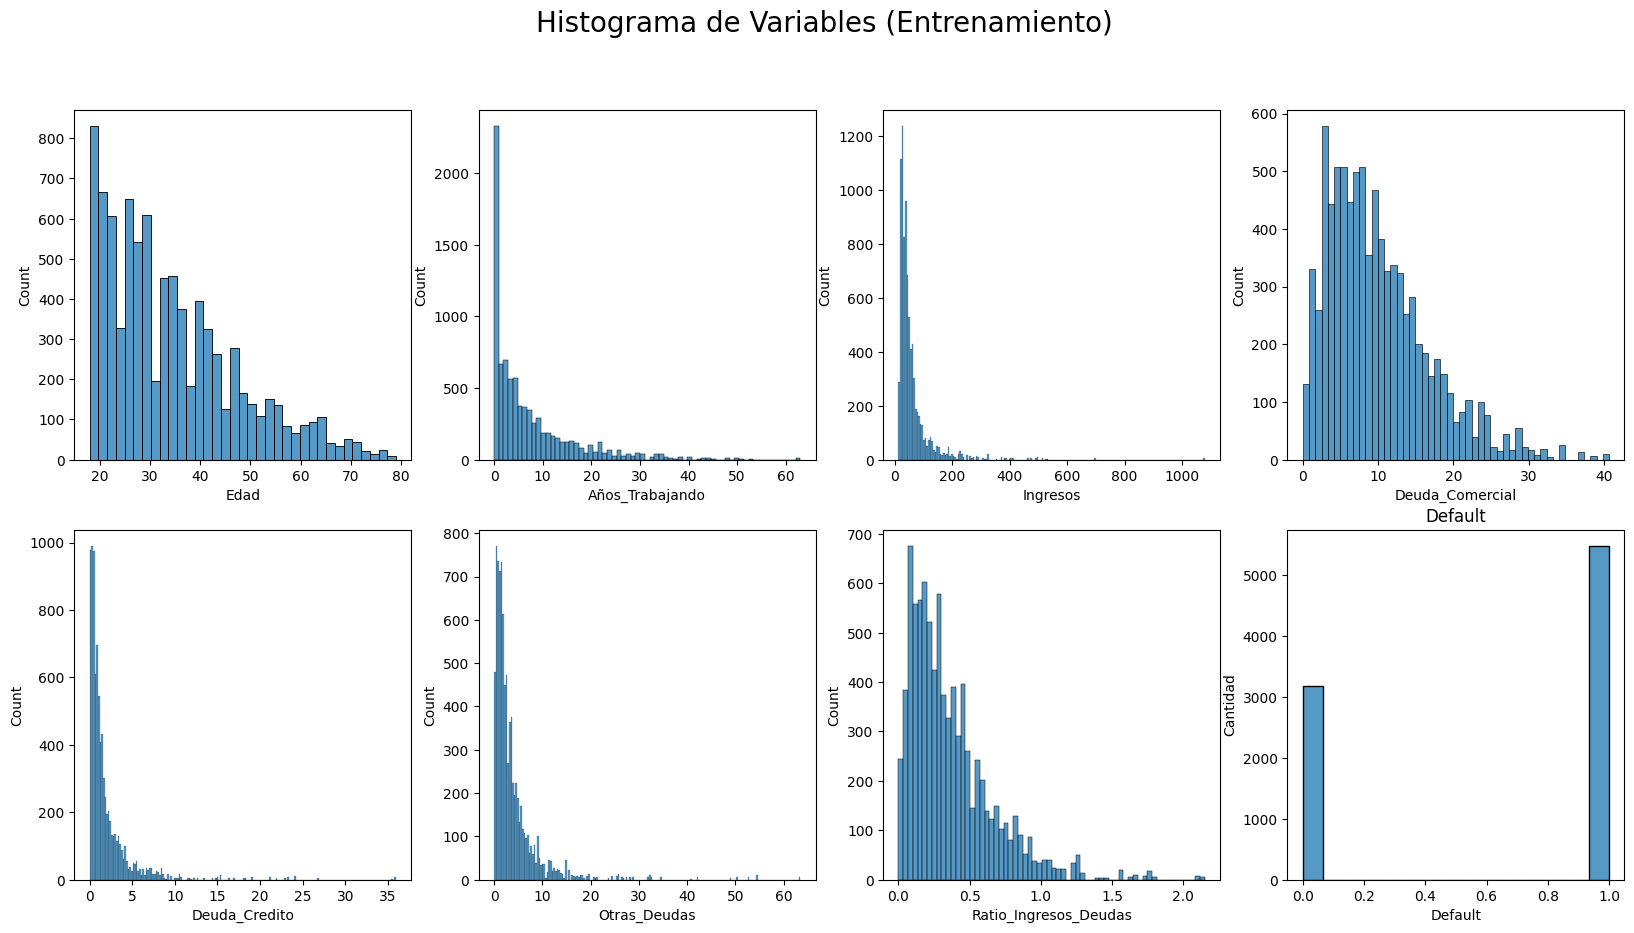

In [135]:
def graficar_histograma_subplots(df, variable, ax ):
    sns.histplot(df, x = variable, ax = ax)
    plt.title(f"{variable}")
    plt.xlabel(f"{variable}")
    plt.ylabel("Cantidad")

fig, axes = plt.subplots(2,4, figsize = (20,10))
axes = axes.flatten()
for ax, var in zip(axes, df_train.columns):
    graficar_histograma_subplots(df_train, var, ax=ax)

fig.suptitle("Histograma de Variables (Entrenamiento)", fontsize=20)
plt.show()

NameError: name 'df_train_nuevo' is not defined

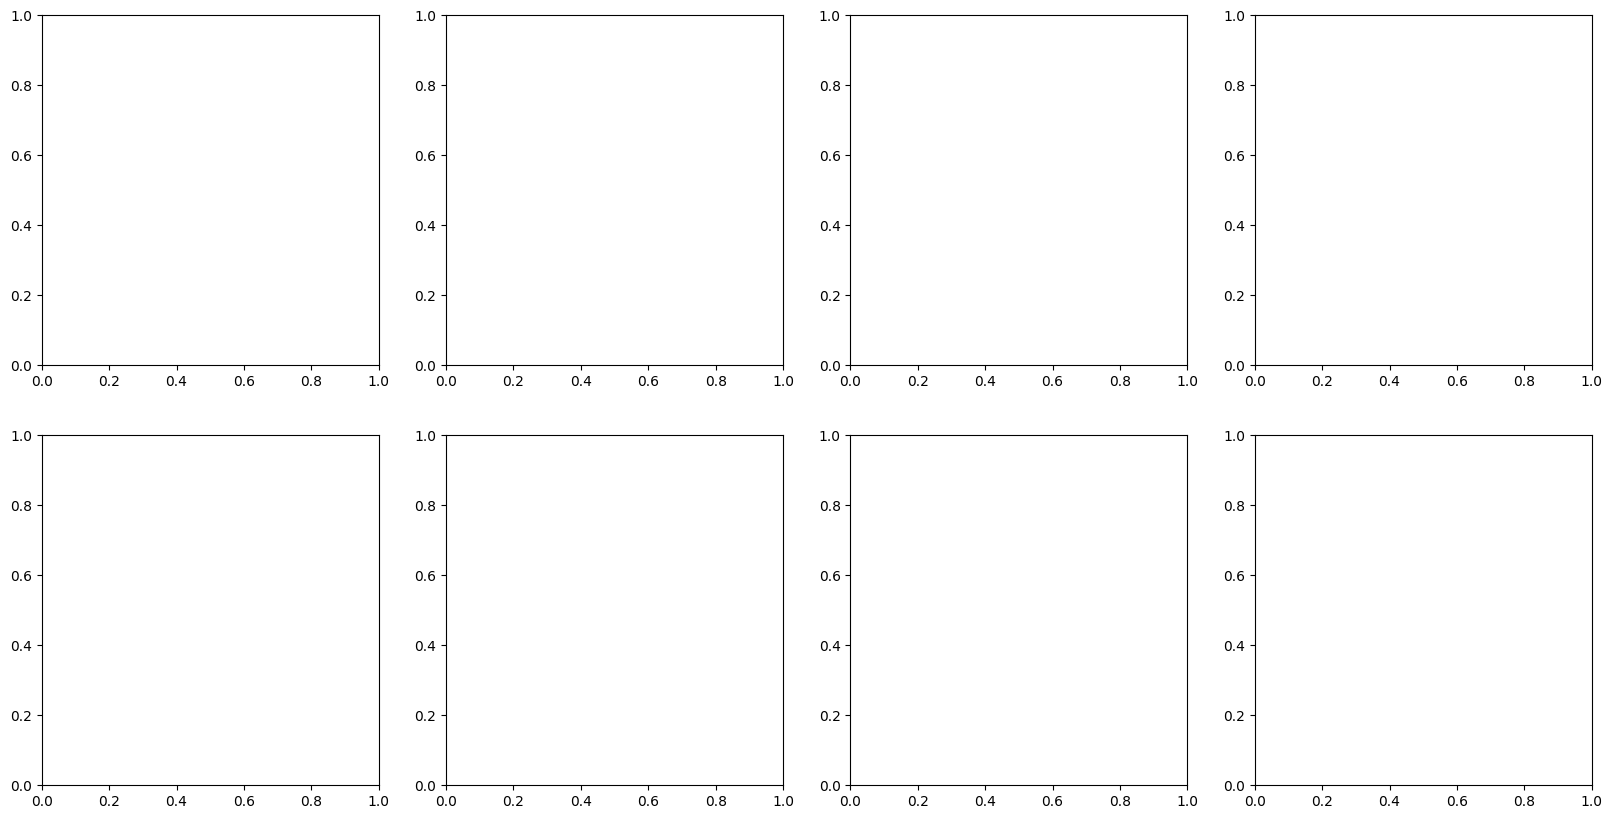

In [136]:
def graficar_histograma_subplots(df, variable, ax ):
    sns.histplot(df, x = variable, ax = ax)
    plt.title(f"{variable}")
    plt.xlabel(f"{variable}")
    plt.ylabel("Cantidad")

fig, axes = plt.subplots(2,4, figsize = (20,10))
axes = axes.flatten()
for ax, var in zip(axes, df_train_nuevo.columns):
    graficar_histograma_subplots(df_train_nuevo, var, ax=ax)

fig.suptitle("Histograma de Variables (Entrenamiento)", fontsize=20)
plt.show()

In [ ]:
modelo_stepwise(x_train_nuevo, x_test_nuevo, y_train, y_test, "backward")

Valor de Accuracy: 0.7615322363096844
Variables seleccionadas con RFE:
Index(['Años_Trabajando', 'Ingresos', 'Deuda_Credito', 'Otras_Deudas',
       'Ratio_Ingresos_Deudas', 'Nivel_Educacional_SupCom'],
      dtype='object')
Intercepto: -0.964163118558056
                   Variable  Coeficiente
0           Años_Trabajando     1.070985
1                  Ingresos     0.766007
2             Deuda_Credito    -1.728157
3              Otras_Deudas    -0.579304
4     Ratio_Ingresos_Deudas    -1.604306
5  Nivel_Educacional_SupCom    -0.448602


In [ ]:
modelo_stepwise(x_train_nuevo, x_test_nuevo, y_train, y_test, "forward")

Valor de Accuracy: 0.7709738332883733
Variables seleccionadas con RFE:
Index(['Edad', 'Años_Trabajando', 'Deuda_Comercial', 'Deuda_Credito',
       'Ratio_Ingresos_Deudas'],
      dtype='object')
Intercepto: -1.8845748313601738
                Variable  Coeficiente
0                   Edad     1.224066
1        Años_Trabajando     0.871212
2        Deuda_Comercial    -0.540146
3          Deuda_Credito    -1.500730
4  Ratio_Ingresos_Deudas    -1.518710


## Modelo con ponderacion de pesos

### Forma Profesor

In [137]:
media_train = y_train.mean()
peso = media_train/(1-media_train)
peso_train = np.where(y_train ==1, 1, peso)

In [138]:
RL = LogisticRegression()

RL.fit(x_train, y_train, sample_weight=peso_train)
y_predic = RL.predict(x_test)

acc = accuracy_score(y_test, y_predic)
print("El accuracy del modelo es")
print(f"El Accuracy del modelo es {acc:.3f}")


coef = RL.coef_[0]
intercepto = RL.intercept_[0]

df_coef = pd.DataFrame({
    "Variable": variables,
    "Coeficiente": coef
})

print("Intercepto:", intercepto)
print(df_coef)


El accuracy del modelo es
El Accuracy del modelo es 0.744
Intercepto: -0.2607835297300455
                    Variable  Coeficiente
0                       Edad     0.034590
1            Años_Trabajando     0.220889
2                   Ingresos     0.001921
3            Deuda_Comercial    -0.091877
4              Deuda_Credito    -0.489906
5               Otras_Deudas    -0.037538
6      Ratio_Ingresos_Deudas    -0.129346
7      Nivel_Educacional_Med    -0.056565
8     Nivel_Educacional_Posg     0.346946
9   Nivel_Educacional_SupCom    -0.229101
10  Nivel_Educacional_SupInc     0.081067


In [139]:
def modelo_stepwise(x_train, x_test, y_train, y_test, direccion):
    modelo = LogisticRegression()
    stepwise = SequentialFeatureSelector(
        modelo,
        direction = direccion,
        scoring = "accuracy",
        cv=5,

    )

    stepwise.fit(x_train, y_train)
    filtro = stepwise.get_support()
    col_stepwise = x_train.columns[filtro]
    modelo.fit(x_train[col_stepwise], y_train, sample_weight= peso_train)
    y_pred = modelo.predict(x_test[col_stepwise])

    accuracy = accuracy_score(y_pred, y_test)

    print(f"Valor de Accuracy: {accuracy}")
    print("Variables seleccionadas con RFE:")
    print(col_stepwise)
    
    coef = modelo.coef_[0]
    intercepto = modelo.intercept_[0]

    df_coef = pd.DataFrame({
    "Variable": col_stepwise,
    "Coeficiente": coef})

    print("Intercepto:", intercepto)
    print(df_coef)

    return  modelo, col_stepwise


modelo, col_selecc = modelo_stepwise(x_train, x_test, y_train, y_test, "backward")


Valor de Accuracy: 0.740221203129215
Variables seleccionadas con RFE:
Index(['Edad', 'Años_Trabajando', 'Deuda_Comercial', 'Deuda_Credito',
       'Nivel_Educacional_Posg', 'Nivel_Educacional_SupCom'],
      dtype='object')
Intercepto: -0.19259337532986529
                   Variable  Coeficiente
0                      Edad     0.035582
1           Años_Trabajando     0.215184
2           Deuda_Comercial    -0.109578
3             Deuda_Credito    -0.482021
4    Nivel_Educacional_Posg     0.398629
5  Nivel_Educacional_SupCom    -0.234234


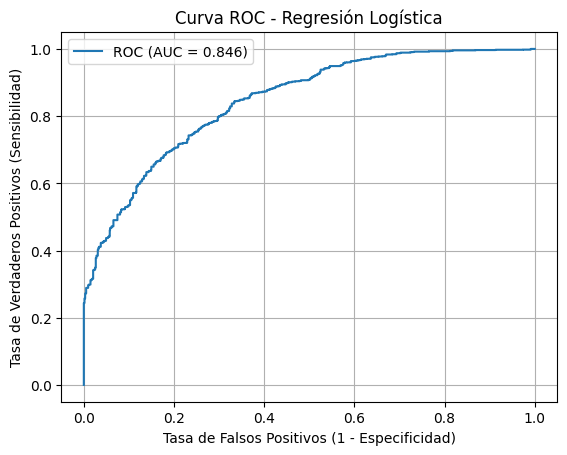

In [140]:
y_scores = modelo.predict_proba(x_test[col_selecc])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.grid(True)
plt.show()

In [141]:
#### Crear otro threshold

thresholds = np.arange(0, 1.01, 0.01)   # thresholds de 0.00 a 1.00
accuracies = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_t))

best_t = thresholds[np.argmax(accuracies)]
best_acc = max(accuracies)

print(f"Mejor threshold = {best_t:.2f}")
print(f"Accuracy máximo = {best_acc:.4f}")

Mejor threshold = 0.37
Accuracy máximo = 0.7791


### Forma balanceo recomendada Default

In [142]:
N = len(x_train)
N1 = y_train.sum()
N0 = N-N1

w0 = N/(2*N0)
w1 = N/(2*N1)

peso_train2 = np.where(y_train==1, w1,w0)

In [143]:
RL = LogisticRegression()

RL.fit(x_train, y_train, sample_weight=peso_train2)
y_predic = RL.predict(x_test)

acc = accuracy_score(y_test, y_predic)
print("El accuracy del modelo es")
print(f"El Accuracy del modelo es {acc:.3f}")


coef = RL.coef_[0]
intercepto = RL.intercept_[0]

df_coef = pd.DataFrame({
    "Variable": variables,
    "Coeficiente": coef
})

print("Intercepto:", intercepto)
print(df_coef)

El accuracy del modelo es
El Accuracy del modelo es 0.739
Intercepto: -0.2192818763517801
                    Variable  Coeficiente
0                       Edad     0.034372
1            Años_Trabajando     0.219548
2                   Ingresos     0.001623
3            Deuda_Comercial    -0.096949
4              Deuda_Credito    -0.485904
5               Otras_Deudas    -0.030000
6      Ratio_Ingresos_Deudas    -0.088336
7      Nivel_Educacional_Med    -0.038393
8     Nivel_Educacional_Posg     0.278210
9   Nivel_Educacional_SupCom    -0.291000
10  Nivel_Educacional_SupInc     0.081909


In [144]:
def modelo_stepwise(x_train, x_test, y_train, y_test, direccion):
    modelo = LogisticRegression()
    stepwise = SequentialFeatureSelector(
        modelo,
        direction = direccion,
        scoring = "accuracy",
        cv=5,

    )

    stepwise.fit(x_train, y_train)
    filtro = stepwise.get_support()
    col_stepwise = x_train.columns[filtro]
    modelo.fit(x_train[col_stepwise], y_train, sample_weight= peso_train2)
    y_pred = modelo.predict(x_test[col_stepwise])

    accuracy = accuracy_score(y_pred, y_test)

    print(f"Valor de Accuracy: {accuracy}")
    print("Variables seleccionadas con RFE:")
    print(col_stepwise)
    
    coef = modelo.coef_[0]
    intercepto = modelo.intercept_[0]

    df_coef = pd.DataFrame({
    "Variable": col_stepwise,
    "Coeficiente": coef})

    print("Intercepto:", intercepto)
    print(df_coef)


modelo_stepwise(x_train, x_test, y_train, y_test, "backward")

Valor de Accuracy: 0.740221203129215
Variables seleccionadas con RFE:
Index(['Edad', 'Años_Trabajando', 'Deuda_Comercial', 'Deuda_Credito',
       'Nivel_Educacional_Posg', 'Nivel_Educacional_SupCom'],
      dtype='object')
Intercepto: -0.19262734302503204
                   Variable  Coeficiente
0                      Edad     0.035586
1           Años_Trabajando     0.215160
2           Deuda_Comercial    -0.109578
3             Deuda_Credito    -0.481964
4    Nivel_Educacional_Posg     0.397278
5  Nivel_Educacional_SupCom    -0.234177


In [145]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8649 entries, 8694 to 9412
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Edad                      8649 non-null   int64  
 1   Años_Trabajando           8649 non-null   int64  
 2   Ingresos                  8649 non-null   int64  
 3   Deuda_Comercial           8649 non-null   float64
 4   Deuda_Credito             8649 non-null   float64
 5   Otras_Deudas              8649 non-null   float64
 6   Ratio_Ingresos_Deudas     8649 non-null   float64
 7   Nivel_Educacional_Med     8649 non-null   bool   
 8   Nivel_Educacional_Posg    8649 non-null   bool   
 9   Nivel_Educacional_SupCom  8649 non-null   bool   
 10  Nivel_Educacional_SupInc  8649 non-null   bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 574.3 KB


In [146]:
# --- 1. Definimos qué columnas vamos a binnear ---
cols_binning = [
    "Edad", "Años_Trabajando", "Ingresos",
    "Deuda_Comercial", "Deuda_Credito",
    "Otras_Deudas", "Ratio_Ingresos_Deudas"
]

cols_dummies = [
    "Nivel_Educacional_Med", "Nivel_Educacional_Posg",
    "Nivel_Educacional_SupCom", "Nivel_Educacional_SupInc"
]

# Número de bins
N_BINS = 5  

# Para guardar los bordes de cada bin
bin_edges = {}

# --- 2. Hacemos binning SOLO en x_train ---
x_train_binned = x_train.copy()

for col in cols_binning:
    # Generamos bins por cuantiles en TRAIN
    x_train_binned[col + "_bin"], edges = pd.qcut(
        x_train[col],
        q=N_BINS,
        retbins=True,
        duplicates="drop"
    )
    bin_edges[col] = edges  # Guardamos bordes exactos

# --- 3. Función que aplica los mismos bins a cualquier dataset ---
def aplicar_binning(df, cols_binning, bin_edges):
    df_binned = df.copy()
    for col in cols_binning:
        edges = bin_edges[col]  # bordes del train
        df_binned[col + "_bin"] = pd.cut(
            df[col],
            bins=edges,
            include_lowest=True
        )
    return df_binned

# --- 4. Aplicamos binning a x_test usando los bordes del train ---
x_test_binned = aplicar_binning(x_test, cols_binning, bin_edges)

# --- 5. Dejamos SOLO las columnas necesarias ---
cols_final = [c + "_bin" for c in cols_binning] + cols_dummies

x_train_model = x_train_binned[cols_final]
x_test_model  = x_test_binned[cols_final]

print("Train binned:")
print(x_train_model.head())

print("\nTest binned:")
print(x_test_model.head())


Train binned:
             Edad_bin Años_Trabajando_bin    Ingresos_bin Deuda_Comercial_bin  \
8694   (17.999, 22.0]       (-0.001, 2.0]  (11.999, 25.0]       (-0.001, 4.1]   
10199  (17.999, 22.0]       (-0.001, 2.0]  (11.999, 25.0]       (-0.001, 4.1]   
11129    (45.0, 79.0]        (12.0, 63.0]  (73.0, 1079.0]          (4.1, 6.9]   
9727     (22.0, 28.0]       (-0.001, 2.0]  (11.999, 25.0]         (6.9, 10.4]   
8294   (17.999, 22.0]       (-0.001, 2.0]    (34.0, 47.0]       (-0.001, 4.1]   

      Deuda_Credito_bin Otras_Deudas_bin Ratio_Ingresos_Deudas_bin  \
8694    (-0.001, 0.346]    (-0.001, 0.9]            (-0.001, 0.13]   
10199   (-0.001, 0.346]    (-0.001, 0.9]              (0.13, 0.23]   
11129      (1.35, 2.81]     (3.01, 5.43]            (-0.001, 0.13]   
9727      (0.346, 0.74]      (0.9, 1.72]              (0.36, 0.56]   
8294    (-0.001, 0.346]      (0.9, 1.72]            (-0.001, 0.13]   

       Nivel_Educacional_Med  Nivel_Educacional_Posg  \
8694                  

In [147]:
x_test_model.columns

Index(['Edad_bin', 'Años_Trabajando_bin', 'Ingresos_bin',
       'Deuda_Comercial_bin', 'Deuda_Credito_bin', 'Otras_Deudas_bin',
       'Ratio_Ingresos_Deudas_bin', 'Nivel_Educacional_Med',
       'Nivel_Educacional_Posg', 'Nivel_Educacional_SupCom',
       'Nivel_Educacional_SupInc'],
      dtype='object')

In [148]:
col_binn = x_test_model.columns[0:7]

In [149]:
x_test_model

,Edad_bin,Años_Trabajando_bin,Ingresos_bin,Deuda_Comercial_bin,Deuda_Credito_bin,Otras_Deudas_bin,Ratio_Ingresos_Deudas_bin,Nivel_Educacional_Med,Nivel_Educacional_Posg,Nivel_Educacional_SupCom,Nivel_Educacional_SupInc
2933,"(35.0, 45.0]","(5.0, 12.0]","(47.0, 73.0]","(4.1, 6.9]","(0.346, 0.74]","(3.01, 5.43]","(0.13, 0.23]",False,False,False,True
601,"(22.0, 28.0]","(-0.001, 2.0]","(11.999, 25.0]","(4.1, 6.9]","(0.74, 1.35]","(-0.001, 0.9]","(0.23, 0.36]",False,False,True,False
7788,"(17.999, 22.0]","(-0.001, 2.0]","(11.999, 25.0]","(10.4, 14.9]","(0.74, 1.35]","(0.9, 1.72]","(0.56, 2.15]",False,False,False,False
6455,"(35.0, 45.0]","(12.0, 63.0]","(11.999, 25.0]","(14.9, 40.7]","(1.35, 2.81]","(0.9, 1.72]","(0.56, 2.15]",False,False,False,True
6190,"(17.999, 22.0]","(-0.001, 2.0]","(11.999, 25.0]","(10.4, 14.9]","(0.346, 0.74]","(0.9, 1.72]","(0.56, 2.15]",False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
10366,"(45.0, 79.0]","(-0.001, 2.0]","(25.0, 34.0]","(4.1, 6.9]","(-0.001, 0.346]","(1.72, 3.01]","(0.23, 0.36]",True,False,False,False
2094,"(35.0, 45.0]","(5.0, 12.0]","(34.0, 47.0]","(4.1, 6.9]","(1.35, 2.81]","(-0.001, 0.9]","(0.23, 0.36]",True,False,False,False
4347,"(17.999, 22.0]","(-0.001, 2.0]","(11.999, 25.0]","(6.9, 10.4]","(0.74, 1.35]","(-0.001, 0.9]","(0.56, 2.15]",True,False,False,False
2423,"(28.0, 35.0]","(5.0, 12.0]","(34.0, 47.0]","(10.4, 14.9]","(0.74, 1.35]","(3.01, 5.43]","(0.36, 0.56]",False,False,False,True


In [150]:
x_train_model= pd.get_dummies(x_train_model[col_binn], drop_first= True)
x_test_model =pd.get_dummies(x_test_model[col_binn] , drop_first= True)

In [151]:
x_test_model

,"Edad_bin_(22.0, 28.0]","Edad_bin_(28.0, 35.0]","Edad_bin_(35.0, 45.0]","Edad_bin_(45.0, 79.0]","Años_Trabajando_bin_(2.0, 5.0]","Años_Trabajando_bin_(5.0, 12.0]","Años_Trabajando_bin_(12.0, 63.0]","Ingresos_bin_(25.0, 34.0]","Ingresos_bin_(34.0, 47.0]","Ingresos_bin_(47.0, 73.0]",...,"Deuda_Credito_bin_(1.35, 2.81]","Deuda_Credito_bin_(2.81, 35.97]","Otras_Deudas_bin_(0.9, 1.72]","Otras_Deudas_bin_(1.72, 3.01]","Otras_Deudas_bin_(3.01, 5.43]","Otras_Deudas_bin_(5.43, 63.47]","Ratio_Ingresos_Deudas_bin_(0.13, 0.23]","Ratio_Ingresos_Deudas_bin_(0.23, 0.36]","Ratio_Ingresos_Deudas_bin_(0.36, 0.56]","Ratio_Ingresos_Deudas_bin_(0.56, 2.15]"
2933,False,False,True,False,False,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
601,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7788,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
6455,False,False,True,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,True
6190,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10366,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
2094,False,False,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4347,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2423,False,True,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False


In [152]:
x_train_model

,"Edad_bin_(22.0, 28.0]","Edad_bin_(28.0, 35.0]","Edad_bin_(35.0, 45.0]","Edad_bin_(45.0, 79.0]","Años_Trabajando_bin_(2.0, 5.0]","Años_Trabajando_bin_(5.0, 12.0]","Años_Trabajando_bin_(12.0, 63.0]","Ingresos_bin_(25.0, 34.0]","Ingresos_bin_(34.0, 47.0]","Ingresos_bin_(47.0, 73.0]",...,"Deuda_Credito_bin_(1.35, 2.81]","Deuda_Credito_bin_(2.81, 35.97]","Otras_Deudas_bin_(0.9, 1.72]","Otras_Deudas_bin_(1.72, 3.01]","Otras_Deudas_bin_(3.01, 5.43]","Otras_Deudas_bin_(5.43, 63.47]","Ratio_Ingresos_Deudas_bin_(0.13, 0.23]","Ratio_Ingresos_Deudas_bin_(0.23, 0.36]","Ratio_Ingresos_Deudas_bin_(0.36, 0.56]","Ratio_Ingresos_Deudas_bin_(0.56, 2.15]"
8694,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10199,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
11129,False,False,False,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,False,False
9727,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
8294,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5699,False,False,False,True,True,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
10742,False,False,True,False,False,True,False,False,True,False,...,True,False,True,False,False,False,False,True,False,False
537,False,False,True,False,True,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False


In [153]:
modelo_binned = LogisticRegression()

modelo_binned.fit(x_train_model, y_train)
y_pred_binned = modelo_binned.predict(x_test_model)
accuracy = accuracy_score(y_test, y_pred_binned)
print(accuracy)

0.748044240625843


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# Modelo base
logreg = LogisticRegression(max_iter=1000)

# Número de variables
n_features = x_train_model.shape[1]

mejor_acc = 0
mejores_vars = None

# IMPORTANTE: backward permite seleccionar desde n_features-1 hasta 1
for k in range(1, n_features):
    print(f"Probando con {k} variables...")

    # Backward en sklearn
    sbs = SequentialFeatureSelector(
        logreg,
        n_features_to_select=k,
        direction="backward",
        scoring="accuracy",  # puedes usar "roc_auc"
        cv=5,
        n_jobs=-1
    )

    sbs.fit(x_train_model, y_train)

    # Variables seleccionadas
    selected_mask = sbs.get_support()
    selected_features = x_train_model.columns[selected_mask]

    # Entrenamos modelo con esas variables
    modelo_backward = LogisticRegression(max_iter=1000)
    modelo_backward.fit(x_train_model[selected_features], y_train)

    # Evaluamos en test
    y_pred = modelo_backward.predict(x_test_model[selected_features])
    acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy con {k} variables: {acc:.5f}")

    # Guardar el mejor resultado
    if acc > mejor_acc:
        mejor_acc = acc
        mejores_vars = selected_features

print("\n====================================")
print("✅ Mejor resultado Backward Stepwise")
print("====================================")
print(f"Accuracy: {mejor_acc:.5f}")
print("Variables seleccionadas:")
print(list(mejores_vars))


Probando con 1 variables...
Accuracy con 1 variables: 0.69760
Probando con 2 variables...
Accuracy con 2 variables: 0.69760
Probando con 3 variables...
Accuracy con 3 variables: 0.71351
Probando con 4 variables...
Accuracy con 4 variables: 0.72808
Probando con 5 variables...
Accuracy con 5 variables: 0.72970
Probando con 6 variables...
Accuracy con 6 variables: 0.73321
Probando con 7 variables...
Accuracy con 7 variables: 0.73779
Probando con 8 variables...
Accuracy con 8 variables: 0.73914
Probando con 9 variables...
Accuracy con 9 variables: 0.73968
Probando con 10 variables...
Accuracy con 10 variables: 0.73671
Probando con 11 variables...
Accuracy con 11 variables: 0.73914
Probando con 12 variables...
Accuracy con 12 variables: 0.74076
Probando con 13 variables...
Accuracy con 13 variables: 0.74076
Probando con 14 variables...
Accuracy con 14 variables: 0.73995
Probando con 15 variables...
Accuracy con 15 variables: 0.73995
Probando con 16 variables...
Accuracy con 16 variables: 0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel("Tabla Trabajo Grupal N°2.xlsx", sheet_name= "Desarrollo")

df.drop(["Id_Cliente"], axis=1, inplace=True)
df.drop(["Ratio_Ingresos_Deudas"], axis=1, inplace=True)
df.drop(["Nivel_Educacional"], axis=1, inplace=True)

# Dropeamos el ratio ingersos deduas, ya que se volverán a generar al momento de generar ratios
df["Total_Deudas"] = df["Deuda_Comercial"] + df["Deuda_Credito"] + df["Otras_Deudas"]
target = 'Default'

# Generar Ratios
col_continuas = [col for col in df.columns if df[col].dtype in ["int64", "float64"] and col != target]

def combinacion_de_variables(df, variables):
    df_2 = df.copy()
    eps = 1e-6 
    for x, y in combinations(variables, 2):
        df_2[f"Prod_{x}_{y}"] = df[x] * df[y]
        df_2[f"Ratio_{x}_{y}"] = df[x] / (df[y] + eps)
        df_2[f"Ratio_{y}_{x}"] = df[y] / (df[x] + eps)
    return df_2

df = combinacion_de_variables(df, col_continuas)

# Aplicacion del split en crudo por ahroa, ya que posteriormente se pasaran a woe
x_en_bruto = df.drop(columns=[target])
y_en_bruto = df[target]
x_train_bruto, X_test_bruto, y_train, y_test = train_test_split(x_en_bruto, y_en_bruto, test_size=0.3, random_state=42, stratify=y_en_bruto)

# Aplicacion del woe e IV
def crear_woes(x_train, target):
    """Calcula WOE sobre una serie y devuelve el mapa y los bins usados"""
    _, bins = pd.qcut(x_train, q=10, duplicates='drop', retbins=True)
    bins[0] = -np.inf
    bins[-1] = np.inf

    # Aplicar bins para calcular WOE
    bineado = pd.cut(x_train, bins=bins).astype(str)

    # Tabla WOE
    df_temp = pd.DataFrame({'bin': bineado, 'target': target})
    grouped = df_temp.groupby('bin')['target'].agg(['count', 'sum'])
    grouped['malos_pagadores'] = grouped['sum'].replace(0, 0.5)
    grouped['buenos_pagadores'] = (grouped['count'] - grouped['sum']).replace(0, 0.5)
    
    total_malos = target.sum()
    total_buenos = target.count() - total_malos
    
    grouped['WOE'] = np.log((grouped['buenos_pagadores'] / total_buenos) / (grouped['malos_pagadores'] / total_malos))
    grouped['IV'] = (grouped['buenos_pagadores']/total_buenos - grouped['malos_pagadores']/total_malos) * grouped['WOE']
    
    return grouped['WOE'].to_dict(), grouped['IV'].sum(), bins

def transformar_a_woe(x_train, tabla_woes, bins):
    """Aplica el WOE a nuevos datos"""
    bineado = pd.cut(x_train, bins=bins).astype(str)
    return bineado.map(tabla_woes).fillna(0) # Si hay nulos (categoría nueva), WOE 0

# --- Aplicar transformación
print("Calculando WOE")

X_train_woe = pd.DataFrame(index=x_train_bruto.index)
X_test_woe = pd.DataFrame(index=X_test_bruto.index)
iv_resumen = {}

for col in x_train_bruto.columns:
    # acalculo woe solo al train, evitamos fuga de informacion
    tabla_woes, iv, bins = crear_woes(x_train_bruto[col], y_train)
    iv_resumen[col] = iv
        
    # luego del calculo sobre test se aplica el woe
    X_train_woe[col] = transformar_a_woe(x_train_bruto[col], tabla_woes, bins)
    X_test_woe[col] = transformar_a_woe(X_test_bruto[col], tabla_woes, bins)

print(f"Variables transformadas: {X_train_woe.shape[1]}")

#ocupamos el IV para descartar variables con IV bajo
iv_umbral = 0.01
variables_fuertes_iv = [k for k, v in iv_resumen.items() if v >= iv_umbral]
print(f"Variables con IV > {iv_umbral}: {len(variables_fuertes_iv)}")

X_train_woe = X_train_woe[variables_fuertes_iv]
X_test_woe = X_test_woe[variables_fuertes_iv]


#APLICACION DE ESTRATEGIAS

# --- A) FORWARD
def aplicar_forward(X_tr, y_tr, X_te, y_te):
    inicial, restante = [], list(X_tr.columns)
    mejor_accuracy = 0
    print("\n----- Forward -----")
    while restante:
        cv_prob = []
        for col in restante:
            m = LogisticRegression(solver='liblinear', random_state=42)
            m.fit(X_tr[inicial + [col]], y_tr)
            cv_prob.append((accuracy_score(y_te, m.predict(X_te[inicial + [col]])), col))
        cv_prob.sort(reverse=True)
        if cv_prob[0][0] > mejor_accuracy:
            mejor_accuracy, mejor_col = cv_prob[0]
            inicial.append(mejor_col)
            restante.remove(mejor_col)
            print(f"Agregada: {cv_prob[0][1]} (Acc: {mejor_accuracy:.4f})")
        else: break
    return inicial, mejor_accuracy

# --- B) BACKWARD CON TOLERANCIA
def aplicar_backward(X_tr, y_tr, X_te, y_te, tolerancia=0.001):
    """
    Elimina variables si el accuracy no baja más que la torelancia.
    tolerancia=0.001 significa que aceptamos perder un 0.01% de accuracy a cambio de quitar una variable.
    """
    cols = list(X_tr.columns)
    m = LogisticRegression(solver='liblinear', random_state=42)
    m.fit(X_tr[cols], y_tr)
    mejor_accuracy = accuracy_score(y_te, m.predict(X_te[cols]))
    
    print(f"\n--- Backward (Tolerancia: {tolerancia}) ---")
    print(f"Inicio: {len(cols)} vars | Acc: {mejor_accuracy:.4f}")
    
    loop = True
    while loop and len(cols) > 1:
        cv_prob = []
        # Evaluar qué pasa si quitamos cada variable
        for col in cols:
            temporal_col = [f for f in cols if f != col]
            m.fit(X_tr[temporal_col], y_tr)
            acc = accuracy_score(y_te, m.predict(X_te[temporal_col]))
            cv_prob.append((acc, col))
        
        cv_prob.sort(reverse=True)
        accuracy_sin_var, variables_quitadas = cv_prob[0]
        
        # Si el accuracy al quitar la variable es MAYOR o IGUAL a (Accuracy Actual - Tolerancia)
        # Significa que la pérdida es aceptable, así que la quitamos
        if accuracy_sin_var >= (mejor_accuracy - tolerancia):
            cols.remove(variables_quitadas)
            # Solo actualizamos el mejor_accuracy si realmente mejoró
            # pero aceptamos el nuevo estado más simple.
            if accuracy_sin_var > mejor_accuracy:
                mejor_accuracy = accuracy_sin_var
            print(f"Eliminada: {variables_quitadas} (Acc: {accuracy_sin_var:.4f})")
        else:
            print("No se puede eliminar más sin sacrificar accuracy")
            loop = False
            
    return cols, mejor_accuracy

# --- C) STEPWISE BIDIRECCIONAL---
def stepwise_bidireccional(X_tr, y_tr, X_te, y_te):
    """Agrega la mejor, luego intenta eliminar la peor"""
    col_actual = []
    restante = list(X_tr.columns)
    mejor_accuracy = 0
    
    print("\n----- Stepwise bidireccional-----")
    while restante:
        # 1. Paso Forward
        acc_agregados = []
        for col in restante:
            m = LogisticRegression(solver='liblinear', random_state=42)
            m.fit(X_tr[col_actual + [col]], y_tr)
            acc = accuracy_score(y_te, m.predict(X_te[col_actual + [col]]))
            acc_agregados.append((acc, col))
        acc_agregados.sort(reverse=True)
        
        if acc_agregados[0][0] > mejor_accuracy:
            mejor_accuracy, agregado = acc_agregados[0]
            col_actual.append(agregado)
            restante.remove(agregado)
            print(f"Agregada: {agregado} (Acc: {mejor_accuracy:.4f})")
            
            # 2. Paso Backward (quita variables)
            # Revisamos si alguna de las QUE YA TENEMOS sobra
            if len(col_actual) > 2:
                acc_quitados = []
                for col in col_actual:
                    temp = [f for f in col_actual if f != col]
                    m.fit(X_tr[temp], y_tr)
                    acc = accuracy_score(y_te, m.predict(X_te[temp]))
                    acc_quitados.append((acc, col))
                acc_quitados.sort(reverse=True)
                
                # Si al quitar una mejoramos el mejor_accuracy actual, la sacamos
                if acc_quitados[0][0] > mejor_accuracy:
                    mejor_accuracy, quitados = acc_quitados[0]
                    col_actual.remove(quitados)
                    restante.append(quitados)
                    print(f"Eliminada por redundancia: {quitados} (Acc subió a: {mejor_accuracy:.4f})")
        else:
            break
            
    return col_actual, mejor_accuracy


mejor_fwd, acc_fwd = aplicar_forward(X_train_woe, y_train, X_test_woe, y_test)

mejor_bwd, acc_bwd = aplicar_backward(X_train_woe, y_train, X_test_woe, y_test, tolerancia=0.0005)

mejor_bidir, acc_bidir = stepwise_bidireccional(X_train_woe, y_train, X_test_woe, y_test)

# --- RESULTADOS
print("\n" + "="*30)
print(" COMPARATIVA FINAL")
print("="*30)
print(f"1. Forward:        {acc_fwd:.4f} ({len(mejor_fwd)} variables)")
print(f"2. Backward:       {acc_bwd:.4f} ({len(mejor_bwd)} variables)")
print(f"3. Bidireccional:  {acc_bidir:.4f} ({len(mejor_bidir)} va   riables)")

# guarda y luego muestra resultados de los intentos y los ordenamos de mayor a menor
resultados = [
    ('Forward', acc_fwd, len(mejor_fwd), mejor_fwd),
    ('Backward Smart', acc_bwd, len(mejor_bwd), mejor_bwd),
    ('Bidireccional', acc_bidir, len(mejor_bidir), mejor_bidir)
]

# Ordenamos por Accuracy descendente
resultados.sort(key=lambda x: x[1], reverse=True)

nombre_ganador, acc_ganador, ganadores_var_len, variables_ganadores = resultados[0]
print(f"\n>>> Estrategia ganadora: {nombre_ganador}")

# ENTRENAMIENTO FINAL
modelo_final = LogisticRegression(solver='liblinear', random_state=42)
modelo_final.fit(X_train_woe[variables_ganadores], y_train)

# Optimización Threshold
probs = modelo_final.predict_proba(X_test_woe[variables_ganadores])[:, 1]
mejor_t = 0.5; max_acc = 0
for t in np.arange(0.1, 0.9, 0.01):
    acc = accuracy_score(y_test, (probs >= t).astype(int))
    if acc > max_acc: max_acc = acc; mejor_t = t

print(f"Accuracy Optimizado: {max_acc:.4f} (Threshold: {mejor_t:.2f})")

Calculando WOE
Variables transformadas: 70
Variables con IV > 0.01: 70

----- Forward -----
Agregada: Ratio_Total_Deudas_Edad (Acc: 0.7389)
Agregada: Ratio_Años_Trabajando_Deuda_Credito (Acc: 0.7677)
Agregada: Prod_Edad_Ingresos (Acc: 0.7801)
Agregada: Prod_Deuda_Credito_Total_Deudas (Acc: 0.7850)
Agregada: Ratio_Edad_Deuda_Credito (Acc: 0.7853)
Agregada: Ratio_Total_Deudas_Otras_Deudas (Acc: 0.7885)
Agregada: Ratio_Deuda_Credito_Edad (Acc: 0.7896)
Agregada: Ratio_Otras_Deudas_Edad (Acc: 0.7907)
Agregada: Ratio_Edad_Total_Deudas (Acc: 0.7915)
Agregada: Prod_Edad_Otras_Deudas (Acc: 0.7926)
Agregada: Prod_Años_Trabajando_Deuda_Comercial (Acc: 0.7939)
Agregada: Deuda_Credito (Acc: 0.7950)
Agregada: Ratio_Deuda_Comercial_Otras_Deudas (Acc: 0.7969)

--- Backward (Tolerancia: 0.0005) ---
Inicio: 70 vars | Acc: 0.7974
Eliminada: Ratio_Edad_Ingresos (Acc: 0.7990)
Eliminada: Ratio_Total_Deudas_Edad (Acc: 0.7990)
Eliminada: Prod_Otras_Deudas_Total_Deudas (Acc: 0.8004)
Eliminada: Ratio_Ingresos_D

In [ ]:
col_continuas = [col for col in df_train.columns[:-1] if df_train[col].dtype in ["int64", "float64"]]

def combinacion_de_variables(df, variables):
    df_2 = df.copy()
    for x,y in combinations(variables, 2): 
        df_2[f"Prod_{x}_{y}"] = df[x]*df[y]
        df_2[f"Ratio_{x}_{y}"] = df[x] / (df[y] + 0.00000000001)


    return df_2

df_train_total = combinacion_de_variables(df_train, col_continuas)
df_test_total = combinacion_de_variables(df_test, col_continuas)
        

In [ ]:
variables_numericas_total = [col for col in df_train_total.columns if col not in ["Default", "Nivel_Educacional"]]
variables_numericas_total

['Edad',
 'Años_Trabajando',
 'Ingresos',
 'Deuda_Comercial',
 'Deuda_Credito',
 'Otras_Deudas',
 'Ratio_Ingresos_Deudas',
 'Nivel_Educacional_Med',
 'Nivel_Educacional_Posg',
 'Nivel_Educacional_SupCom',
 'Nivel_Educacional_SupInc',
 'Prod_Edad_Años_Trabajando',
 'Ratio_Edad_Años_Trabajando',
 'Prod_Edad_Ingresos',
 'Ratio_Edad_Ingresos',
 'Prod_Edad_Deuda_Comercial',
 'Ratio_Edad_Deuda_Comercial',
 'Prod_Edad_Deuda_Credito',
 'Ratio_Edad_Deuda_Credito',
 'Prod_Edad_Otras_Deudas',
 'Ratio_Edad_Otras_Deudas',
 'Prod_Edad_Ratio_Ingresos_Deudas',
 'Ratio_Edad_Ratio_Ingresos_Deudas',
 'Prod_Edad_Default',
 'Ratio_Edad_Default',
 'Prod_Años_Trabajando_Ingresos',
 'Ratio_Años_Trabajando_Ingresos',
 'Prod_Años_Trabajando_Deuda_Comercial',
 'Ratio_Años_Trabajando_Deuda_Comercial',
 'Prod_Años_Trabajando_Deuda_Credito',
 'Ratio_Años_Trabajando_Deuda_Credito',
 'Prod_Años_Trabajando_Otras_Deudas',
 'Ratio_Años_Trabajando_Otras_Deudas',
 'Prod_Años_Trabajando_Ratio_Ingresos_Deudas',
 'Ratio_Años

In [ ]:
variables_backward = ['Ingresos', 'Deuda_Credito', 'Prod_Edad_Deuda_Comercial',
       'Prod_Edad_Otras_Deudas', 'Ratio_Edad_Otras_Deudas',
       'Prod_Edad_Ratio_Ingresos_Deudas', 'Ratio_Edad_Ratio_Ingresos_Deudas',
       'Prod_Años_Trabajando_Ingresos', 'Prod_Años_Trabajando_Deuda_Comercial',
       'Prod_Años_Trabajando_Deuda_Credito',
       'Ratio_Años_Trabajando_Deuda_Credito',
       'Prod_Años_Trabajando_Otras_Deudas',
       'Ratio_Años_Trabajando_Otras_Deudas',
       'Prod_Años_Trabajando_Ratio_Ingresos_Deudas',
       'Prod_Ingresos_Deuda_Credito', 'Prod_Ingresos_Otras_Deudas',
       'Ratio_Ingresos_Ratio_Ingresos_Deudas',
       'Ratio_Deuda_Comercial_Deuda_Credito',
       'Ratio_Deuda_Comercial_Otras_Deudas',
       'Prod_Deuda_Comercial_Ratio_Ingresos_Deudas',
       'Prod_Deuda_Credito_Ratio_Ingresos_Deudas',
       'Ratio_Deuda_Credito_Ratio_Ingresos_Deudas',
       'Prod_Otras_Deudas_Ratio_Ingresos_Deudas',
       'Ratio_Otras_Deudas_Ratio_Ingresos_Deudas', 'Años_Trabajando', 'Deuda_Comercial',
       'Otras_Deudas'] #Variables que resultaron de iterar todas las variables en un modelo Backward, debido al tiempo de iteracion (Mayor a 2 horas) es que decidimos tomar ese resultado y dejarlo en un arreglo dado que para dejar el codigo con la iteracion nuevamente tendrìamos que volver a dejar prendido un PC por 1 hora

x_train = df_train_total[variables_backward]
y_train = df_train_total["Default"]

x_test = df_test_total[variables_backward]
y_test = df_test_total["Default"]


def modelo_stepwise(x_train, x_test, y_train, y_test, direccion):
    modelo = LogisticRegression()
    stepwise = SequentialFeatureSelector(
        modelo,
        direction = direccion,
        scoring = "accuracy",
        cv=5,

    )

    stepwise.fit(x_train, y_train)
    filtro = stepwise.get_support()
    col_stepwise = x_train.columns[filtro]
    modelo.fit(x_train[col_stepwise], y_train)
    y_pred = modelo.predict(x_test[col_stepwise])

    accuracy = accuracy_score(y_pred, y_test)

    print(f"Valor de Accuracy: {accuracy}")
    print("Variables seleccionadas con RFE:")
    print(col_stepwise)
    
    coef = modelo.coef_[0]
    intercepto = modelo.intercept_[0]

    df_coef = pd.DataFrame({
    "Variable": col_stepwise,
    "Coeficiente": coef})

    print("Intercepto:", intercepto)
    print(df_coef)


modelo_stepwise(x_train, x_test, y_train, y_test, "backward")


Valor de Accuracy: 0.7647693552738063
Variables seleccionadas con RFE:
Index(['Ingresos', 'Deuda_Credito', 'Prod_Edad_Deuda_Comercial',
       'Prod_Edad_Otras_Deudas', 'Ratio_Edad_Ratio_Ingresos_Deudas',
       'Prod_Años_Trabajando_Ingresos', 'Prod_Años_Trabajando_Deuda_Credito',
       'Prod_Años_Trabajando_Otras_Deudas',
       'Ratio_Años_Trabajando_Otras_Deudas', 'Prod_Ingresos_Otras_Deudas',
       'Ratio_Deuda_Comercial_Deuda_Credito',
       'Prod_Deuda_Comercial_Ratio_Ingresos_Deudas',
       'Ratio_Deuda_Credito_Ratio_Ingresos_Deudas', 'Deuda_Comercial'],
      dtype='object')
Intercepto: 0.0031782871203069577
                                      Variable  Coeficiente
0                                     Ingresos     0.022838
1                                Deuda_Credito    -0.018109
2                    Prod_Edad_Deuda_Comercial     0.002855
3                       Prod_Edad_Otras_Deudas    -0.005415
4             Ratio_Edad_Ratio_Ingresos_Deudas     0.000677
5          

In [ ]:
optb = OptimalBinning(name="Edad", dtype="numerical", max_n_bins=10) 
optb.fit(df_train_total["Edad"], df_train_total["Default"])
tabla = optb.binning_table.build()
tabla

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 19.50)",830,0.095965,488,342,0.412048,0.897222,0.081526,0.009862
1,"[19.50, 22.50)",914,0.105677,488,426,0.466083,0.677593,0.051160,0.006275
2,"[22.50, 25.50)",996,0.115158,478,518,0.520080,0.461353,0.025621,0.003175
3,"[25.50, 30.50)",1492,0.172505,658,834,0.558981,0.304689,0.016554,0.002061
4,"[30.50, 33.50)",648,0.074922,225,423,0.652778,-0.089554,0.000593,0.000074
5,"[33.50, 46.50)",2270,0.262458,660,1610,0.709251,-0.350032,0.030438,0.003785
6,"[46.50, 57.50)",873,0.100937,117,756,0.865979,-1.32415,0.134372,0.015668
7,"[57.50, inf)",626,0.072378,67,559,0.892971,-1.57974,0.128225,0.014545
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [ ]:
ivs = []

for col in variables_numericas_total:
    optb = OptimalBinning(name=col, dtype="numerical", max_n_bins=10)
    optb.fit(df_train_total[col], df_train_total["Default"])
    
    tabla = optb.binning_table.build()
    # Opción 1: sumar IV de todos los bins
    iv = tabla["IV"].sum()
    # Opción 2 (más prolija): tomar la fila Totals si aparece
    # iv = tabla.loc["Totals", "Information value"]
    
    ivs.append((col, iv))

ranking_iv = sorted(ivs, key=lambda x: x[1], reverse=True)


for col, iv in ranking_iv:
    print(f"{col} -> IV={iv:.4f}")



Ratio_Años_Trabajando_Deuda_Comercial -> IV=2.6885
Ratio_Años_Trabajando_Deuda_Credito -> IV=2.4512
Ratio_Edad_Deuda_Comercial -> IV=2.2695
Ratio_Años_Trabajando_Otras_Deudas -> IV=2.1988
Ratio_Edad_Ratio_Ingresos_Deudas -> IV=2.0443
Ratio_Años_Trabajando_Ratio_Ingresos_Deudas -> IV=1.9779
Prod_Deuda_Comercial_Ratio_Ingresos_Deudas -> IV=1.5637
Ratio_Ingresos_Deudas -> IV=1.5228
Prod_Deuda_Credito_Ratio_Ingresos_Deudas -> IV=1.4189
Ratio_Ingresos_Deuda_Credito -> IV=1.3907
Ratio_Ingresos_Deuda_Comercial -> IV=1.3564
Deuda_Comercial -> IV=1.3359
Prod_Edad_Años_Trabajando -> IV=1.2416
Ratio_Años_Trabajando_Ingresos -> IV=1.1565
Ratio_Ingresos_Ratio_Ingresos_Deudas -> IV=1.1491
Años_Trabajando -> IV=1.1415
Ratio_Edad_Años_Trabajando -> IV=1.1395
Ratio_Edad_Deuda_Credito -> IV=1.0375
Edad -> IV=0.9370
Prod_Años_Trabajando_Ingresos -> IV=0.9343
Prod_Deuda_Comercial_Deuda_Credito -> IV=0.9234
Prod_Ingresos_Ratio_Ingresos_Deudas -> IV=0.8693
Prod_Otras_Deudas_Ratio_Ingresos_Deudas -> IV=0.863

### Modelo final 2

In [72]:
df_woe = pd.DataFrame()

def crear_df_woe(lista_variables):


    for col in lista_variables:

        if col != "Nivel_Educacional":

            optb = OptimalBinning(
                name=col,
                dtype="numerical",
                max_n_bins=20
            )
            
            optb.fit(
                df_train_total[col].values,
                df_train_total["Default"].values,
                sample_weight=peso_train2
            )
            
            woe_values = optb.transform(df_train_total[col].values, metric="woe")
            
            df_woe[col] = woe_values
        
        else:
    
            col_cat = col

            optb_cat = OptimalBinning(
                name=col_cat,
                dtype="categorical"     # <-- IMPORTANTE
            )

            optb_cat.fit(
                df_train_total[col_cat].astype(str).values,     # por seguridad => str
                df_train_total["Default"].values,
                sample_weight=peso_train2
            )

            woe_cat = optb_cat.transform(
            df_train_total[col_cat].astype(str).values,
            metric="woe"
            )

            df_woe[col_cat] = woe_cat   # agregar al dataframe final


    df_woe["Default"] = df_train_total["Default"].values

    return df_woe


In [73]:
variables_pivote = df_train.columns[:-1]
df_woe = crear_df_woe(variables_pivote)

df_woe.head()

,Edad,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default,Nivel_Educacional_Med,Nivel_Educacional_Posg,Nivel_Educacional_SupCom
0,0.775437,0.744008,0.703280,-1.263577,-0.660904,-0.769840,-1.483108,1,-0.010032,0.009252,-0.114366
1,0.641622,0.670860,0.467732,-0.880034,-0.466172,-0.401626,-0.751052,1,-0.010032,0.009252,-0.114366
2,-1.580682,-2.153508,-0.554694,-0.478627,-0.013365,0.230064,-1.034619,1,-0.010032,0.009252,-0.114366
3,0.305150,0.299250,0.467732,-0.429608,-0.212677,-0.300360,0.385629,1,-0.010032,0.009252,-0.114366
4,0.641622,0.744008,0.097816,-0.880034,-0.466172,-0.300360,-1.034619,1,-0.010032,0.009252,0.410516


In [78]:
df_train_total["Ratio_Años_Trabajando_Deuda_Total"] = df_train_total["Ratio_Años_Trabajando_Deuda_Comercial"] + df_train_total["Ratio_Años_Trabajando_Deuda_Credito"] + df_train_total["Ratio_Años_Trabajando_Otras_Deudas"]

In [79]:
#Variables Jonathan

variables_pivote = ["Edad", "Deuda_Comercial", "Deuda_Credito", "Años_Trabajando", "Ratio_Años_Trabajando_Deuda_Total"]
df_woe = crear_df_woe(variables_pivote)

x_train = df_woe[variables_pivote]
y_train = df_woe["Default"]

x_test = df_woe[variables_pivote]
y_test = df_woe["Default"]


def modelo_stepwise(x_train, x_test, y_train, y_test, direccion):
    modelo = LogisticRegression()
    stepwise = SequentialFeatureSelector(
        modelo,
        direction = direccion,
        scoring = "accuracy",
        cv=5,

    )

    stepwise.fit(x_train, y_train)
    filtro = stepwise.get_support()
    col_stepwise = x_train.columns[filtro]
    modelo.fit(x_train[col_stepwise], y_train, sample_weight= peso_train2)
    y_pred = modelo.predict(x_test[col_stepwise])
    y_scores = modelo.predict_proba(x_test[col_stepwise])[:, 1]

    threshold_manual = 0.36

    accuracy = accuracy_score(y_pred, y_test)

    print(f"Valor de Accuracy: {accuracy}")
    print("Variables seleccionadas con RFE:")
    print(col_stepwise)
    
    coef = modelo.coef_[0]
    intercepto = modelo.intercept_[0]

    df_coef = pd.DataFrame({
    "Variable": col_stepwise,
    "Coeficiente": coef})

    print("Intercepto:", intercepto)
    print(df_coef)

    thresholds = np.arange(0, 1.01, 0.01)   # thresholds de 0.00 a 1.00
    accuracies = []

    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_t))

        best_t = thresholds[np.argmax(accuracies)]
        best_acc = max(accuracies)



    print(f"Con el corte optimo {best_t} el Accuracy es: {best_acc}")

    return y_scores, y_pred

y_scores, y_pred = modelo_stepwise(x_train, x_test, y_train, y_test, "backward")

Valor de Accuracy: 0.743901029020696
Variables seleccionadas con RFE:
Index(['Deuda_Comercial', 'Deuda_Credito', 'Años_Trabajando'], dtype='object')
Intercepto: 0.0061919512915387075
          Variable  Coeficiente
0  Deuda_Comercial    -0.868336
1    Deuda_Credito    -1.921153
2  Años_Trabajando    -1.874209
Con el corte optimo 0.33 el Accuracy es: 0.7573129841600185


In [ ]:
df_woe = pd.DataFrame()

def crear_df_woe(lista_variables):


    for col in lista_variables:

        if col != "Nivel_Educacional":

            optb = OptimalBinning(
                name=col,
                dtype="numerical",
                max_n_bins=10
            )
            
            optb.fit(
                df_train_total[col].values,
                df_train_total["Default"].values,
                sample_weight=peso_train2
            )
            
            woe_values = optb.transform(df_train_total[col].values, metric="woe")
            
            df_woe[col] = woe_values
        
        else:
    
            col_cat = col

            optb_cat = OptimalBinning(
                name=col_cat,
                dtype="categorical"     # <-- IMPORTANTE
            )

            optb_cat.fit(
                df_train_total[col_cat].astype(str).values,     # por seguridad => str
                df_train_total["Default"].values,
                sample_weight=peso_train2
            )

            woe_cat = optb_cat.transform(
            df_train_total[col_cat].astype(str).values,
            metric="woe"
            )

            df_woe[col_cat] = woe_cat   # agregar al dataframe final


    df_woe["Default"] = df_train_total["Default"].values

    return df_woe

In [ ]:
df_train_total["Ratio_Años_Trabajando_Deuda_Total"]

8694      0.000000
10199     8.380682
11129    44.226958
9727      5.642521
8294      0.000000
           ...    
4307      0.000000
5699      1.417876
10742     7.607224
537      13.569703
9412     45.733333
Name: Ratio_Años_Trabajando_Deuda_Total, Length: 8649, dtype: float64

In [ ]:
variables_pivote = [
    "Ratio_Años_Trabajando_Deuda_Total",
    "Ratio_Edad_Deuda_Comercial",
    "Ratio_Edad_Ratio_Ingresos_Deudas",
    "Ratio_Años_Trabajando_Ratio_Ingresos_Deudas",
    "Prod_Deuda_Comercial_Ratio_Ingresos_Deudas",
    "Ratio_Ingresos_Deudas",
    "Ratio_Ingresos_Deudas_cuadrado",
    "Prod_Deuda_Credito_Ratio_Ingresos_Deudas",
    "Ratio_Ingresos_Deuda_Credito",
    "Ratio_Ingresos_Deuda_Comercial",
    "Deuda_Comercial",
    "Deuda_Comercial_cuadrado",
    "Prod_Edad_Años_Trabajando",
    "Ratio_Años_Trabajando_Ingresos",
    "Ratio_Ingresos_Ratio_Ingresos_Deudas",
    "Años_Trabajando",
    "Años_Trabajando_cuadrado",
    "Ratio_Edad_Años_Trabajando",
    "Ratio_Edad_Deuda_Credito",
    "Edad",
    "Edad_cuadrado",
    "Prod_Años_Trabajando_Ingresos",
    "Prod_Deuda_Comercial_Deuda_Credito",
    "Prod_Ingresos_Ratio_Ingresos_Deudas",
    "Prod_Otras_Deudas_Ratio_Ingresos_Deudas",
    "Ratio_Ingresos_Otras_Deudas",
    "Prod_Edad_Ratio_Ingresos_Deudas",
    "Ratio_Edad_Otras_Deudas"
]

#variables_pivote = ["Ratio_Años_Trabajando_Deuda_Total", "Ingresos", "Nivel_Educacional", "Deuda_Comercial" ]#, "Prod_Deuda"]# "Edad", "Deuda_Credito", "Años_Trabajando", "Nivel_Educacional"]
df_woe = crear_df_woe(variables_pivote)
x_train = df_woe[variables_pivote]
y_train = df_woe["Default"]

x_test = df_woe[variables_pivote]
y_test = df_woe["Default"]

RL = LogisticRegression(penalty= "l2")

RL.fit(x_train, y_train, sample_weight=peso_train2)
y_predic = RL.predict(x_test)
y_scores = RL.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test, y_predic)
print("El accuracy del modelo es")
print(f"El Accuracy del modelo es {acc:.3f}")


coef = RL.coef_[0]
intercepto = RL.intercept_[0]

df_coef = pd.DataFrame({
    "Variable": variables_pivote,
    "Coeficiente": coef
})

print("Intercepto:", intercepto)
print(df_coef)

thresholds = np.arange(0, 1.01, 0.01)   # thresholds de 0.00 a 1.00
accuracies = []

for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_t))

        best_t = thresholds[np.argmax(accuracies)]
        best_acc = max(accuracies)


print(f"Con el corte optimo {best_t} el Accuracy es: {best_acc}")


El accuracy del modelo es
El Accuracy del modelo es 0.758
Intercepto: 0.07090651209039282
                                       Variable  Coeficiente
0             Ratio_Años_Trabajando_Deuda_Total     0.201574
1                    Ratio_Edad_Deuda_Comercial     0.906009
2              Ratio_Edad_Ratio_Ingresos_Deudas     0.071537
3   Ratio_Años_Trabajando_Ratio_Ingresos_Deudas    -0.422657
4    Prod_Deuda_Comercial_Ratio_Ingresos_Deudas    -0.231951
5                         Ratio_Ingresos_Deudas     0.074215
6                Ratio_Ingresos_Deudas_cuadrado     0.074215
7      Prod_Deuda_Credito_Ratio_Ingresos_Deudas    -0.522625
8                  Ratio_Ingresos_Deuda_Credito    -0.271875
9                Ratio_Ingresos_Deuda_Comercial     0.121682
10                              Deuda_Comercial    -0.242570
11                     Deuda_Comercial_cuadrado    -0.242570
12                    Prod_Edad_Años_Trabajando    -1.104582
13               Ratio_Años_Trabajando_Ingresos    -0.57

In [ ]:
variables_pivote = ["Edad", "Deuda_Credito", "Años_Trabajando", "Nivel_Educacional", "Ratio_Años_Trabajando_Deuda_Total"]
df_woe = crear_df_woe(variables_pivote)
df_woe

,Edad,Deuda_Comercial,Deuda_Credito,Años_Trabajando,Nivel_Educacional,Default,Ratio_Años_Trabajando_Deuda_Comercial,Ratio_Años_Trabajando_Deuda_Credito,Ratio_Años_Trabajando_Otras_Deudas,Ratio_Años_Trabajando_Deuda_Total,...,Ratio_Edad_Años_Trabajando,Ratio_Edad_Deuda_Credito,Edad_cuadrado,Prod_Años_Trabajando_Ingresos,Prod_Deuda_Comercial_Deuda_Credito,Prod_Ingresos_Ratio_Ingresos_Deudas,Prod_Otras_Deudas_Ratio_Ingresos_Deudas,Ratio_Ingresos_Otras_Deudas,Prod_Edad_Ratio_Ingresos_Deudas,Ratio_Edad_Otras_Deudas
0,0.775437,-1.263577,-0.660904,0.744008,-0.057696,1,0.909923,0.744008,0.914815,0.743544,...,0.744984,-0.997321,0.775437,0.762544,-1.198960,-1.309548,-1.281397,-1.222291,-1.067844,-1.469201
1,0.641622,-0.880034,-0.466172,0.670860,-0.503205,1,0.426877,-0.898738,0.187915,-0.677713,...,0.527162,-0.672792,0.641622,0.526635,-0.606368,-0.729245,-0.763147,-0.718884,-0.584898,-0.575440
2,-1.580682,-0.478627,-0.013365,-2.153508,-0.503205,1,-3.923720,-2.098258,-3.236812,-2.455224,...,-1.868132,-0.395544,-1.580682,-1.279983,-0.026254,0.025100,-0.347601,-0.108409,-0.207642,-0.439376
3,0.305150,-0.429608,-0.212677,0.299250,-0.057696,1,0.426877,-0.406386,0.187915,0.297020,...,0.088715,-0.395544,0.305150,0.526635,-0.103469,-0.377357,-0.347601,-0.108409,0.318105,-0.439376
4,0.641622,-0.880034,-0.466172,0.744008,0.410516,1,0.909923,0.744008,0.914815,0.743544,...,0.744984,-0.395544,0.641622,0.762544,-0.606368,-0.729245,-0.763147,-0.718884,-1.067844,-0.439376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8644,0.989487,-0.880034,-0.013365,0.744008,0.018497,1,0.909923,0.744008,0.914815,0.743544,...,0.744984,0.267824,0.989487,0.762544,-0.103469,-0.729245,-0.763147,-1.222291,-1.067844,-0.575440
8645,-1.323245,1.029861,1.141728,-0.209227,0.018497,0,0.909923,2.269664,0.914815,2.220359,...,0.448276,0.725922,-1.323245,-0.162750,2.249341,0.647499,0.831833,0.519203,0.567291,0.300928
8646,-0.354248,-0.429608,0.201366,-0.209227,-0.057696,0,-0.143273,-0.406386,-1.059379,-0.221539,...,0.088715,-0.218299,-0.354248,-0.162750,-0.026254,0.025100,-0.347601,-0.336134,0.318105,-0.439376
8647,-0.348433,-0.880034,-0.212677,-0.209227,0.018497,1,-1.415204,-0.898738,-1.300247,-1.224007,...,0.088715,-0.395544,-0.348433,-0.162750,-0.559616,-0.729245,-0.763147,-0.718884,-0.446132,-0.575440


In [ ]:
variables_pivote = ["Edad", "Deuda_Credito", "Años_Trabajando", "Nivel_Educacional", "Ratio_Años_Trabajando_Deuda_Total"]
df_woe = crear_df_woe(variables_pivote)

x_train = df_woe[variables_pivote]
y_train = df_woe["Default"]

x_test = df_woe[variables_pivote]
y_test = df_woe["Default"]

RL = LogisticRegression()

RL.fit(x_train, y_train, sample_weight=peso_train2)
y_predic = RL.predict(x_test)
y_scores = RL.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test, y_predic)
print("El accuracy del modelo es")
print(f"El Accuracy del modelo es {acc:.3f}")


coef = RL.coef_[0]
intercepto = RL.intercept_[0]

df_coef = pd.DataFrame({
    "Variable": variables_pivote,
    "Coeficiente": coef
})

print("Intercepto:", intercepto)
print(df_coef)

thresholds = np.arange(0, 1.01, 0.01)   # thresholds de 0.00 a 1.00
accuracies = []

for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_t))

        best_t = thresholds[np.argmax(accuracies)]
        best_acc = max(accuracies)


print(f"Con el corte optimo {best_t} el Accuracy es: {best_acc}")


El accuracy del modelo es
El Accuracy del modelo es 0.732
Intercepto: 0.014732766961929732
                            Variable  Coeficiente
0                               Edad    -0.782697
1                      Deuda_Credito    -2.169271
2                    Años_Trabajando    -0.814042
3                  Nivel_Educacional    -0.089421
4  Ratio_Años_Trabajando_Deuda_Total    -0.405686
Con el corte optimo 0.43 el Accuracy es: 0.7501445253786565


# Modelo Final Grupo (INFORME)

En el siguiente codigo se utilizaron todas las herramientas que como grupo pudimos interiorizar anteriormente, las cuales consideran, creacion de variables, transformacion a WOE, seleccion de variables, optimizacion de threshold todo con el fin de entregar el mejor modelo y con el accuracy que como grupo logramos desarrollar  

Es por lo anterior que se vuelve a realizar un modelo y se vuelve a cargar la data desde 0, esto porque generamos un codigo final más limpio y sencillo de leer para que fuera evaluado

In [90]:

def crear_woes(x_train, target):
    """Calcula WOE sobre una serie y devuelve el mapa y los bins usados"""
    _, bins = pd.qcut(x_train, q=10, duplicates='drop', retbins=True)
    bins[0] = -np.inf
    bins[-1] = np.inf

    # Aplicar bins para calcular WOE
    bineado = pd.cut(x_train, bins=bins).astype(str)

    # Tabla WOE
    df_temp = pd.DataFrame({'bin': bineado, 'target': target})
    grouped = df_temp.groupby('bin')['target'].agg(['count', 'sum'])
    grouped['malos_pagadores'] = grouped['sum'].replace(0, 0.5)
    grouped['buenos_pagadores'] = (grouped['count'] - grouped['sum']).replace(0, 0.5)
    
    total_malos = target.sum()
    total_buenos = target.count() - total_malos
    
    grouped['WOE'] = np.log((grouped['buenos_pagadores'] / total_buenos) / (grouped['malos_pagadores'] / total_malos))
    grouped['IV'] = (grouped['buenos_pagadores']/total_buenos - grouped['malos_pagadores']/total_malos) * grouped['WOE']
    
    return grouped['WOE'].to_dict(), grouped['IV'].sum(), bins

def transformar_a_woe(x_train, tabla_woes, bins):
    """Aplica el WOE a nuevos datos"""
    bineado = pd.cut(x_train, bins=bins).astype(str)
    return bineado.map(tabla_woes).fillna(0) # Si hay nulos (categoría nueva), WOE 0


def regresion_y_metricas(df, nombre_de_la_prueba):
    print(f' ============ Estrategia {nombre_de_la_prueba} ============')
    
    if "Id_Cliente" in df.columns: df.drop(["Id_Cliente"], axis=1, inplace=True)
    if "Ratio_Ingresos_Deudas" in df.columns: df.drop(["Ratio_Ingresos_Deudas"], axis=1, inplace=True)

    target = 'Default'

    # Aplicacion del split en crudo por ahroa, ya que posteriormente se pasaran a woe
    x_en_bruto = df.drop(columns=[target])
    y_en_bruto = df[target]
    x_train_bruto, X_test_bruto, y_train, y_test = train_test_split(x_en_bruto, y_en_bruto, test_size=0.3, random_state=42, stratify=y_en_bruto)

    # Aplicacion del woe e IV
    print("Calculando WOE")

    X_train_woe = pd.DataFrame(index=x_train_bruto.index)
    X_test_woe = pd.DataFrame(index=X_test_bruto.index)
    iv_resumen = {}

    for col in x_train_bruto.columns:
        # acalculo del woe solo al train, evitamos fuga de informacion
        tabla_woes, iv, bins = crear_woes(x_train_bruto[col], y_train)
        iv_resumen[col] = iv
            
        # luego del calculo sobre test se aplica el woe
        X_train_woe[col] = transformar_a_woe(x_train_bruto[col], tabla_woes, bins)
        X_test_woe[col] = transformar_a_woe(X_test_bruto[col], tabla_woes, bins)

    print(f"Variables transformadas: {X_train_woe.shape[1]}")

    #ocupamos el IV para descartar variables con IV bajo
    iv_umbral = 0.01
    variables_fuertes_iv = [k for k, v in iv_resumen.items() if v >= iv_umbral]
    print(f"Variables con IV > {iv_umbral}: {len(variables_fuertes_iv)}")

    X_train_woe = X_train_woe[variables_fuertes_iv]
    X_test_woe = X_test_woe[variables_fuertes_iv]

    print("\nResumen del IV:")
    iv_df = pd.DataFrame(list(iv_resumen.items()), columns=['Variable', 'IV']).sort_values('IV', ascending=False)
    print(iv_df)
    
    RL = LogisticRegression(solver='liblinear', random_state=42)
    RL.fit(X_train_woe, y_train)
    y_predic = RL.predict(X_test_woe)

    acc = accuracy_score(y_test, y_predic)
    print(f"\n{nombre_de_la_prueba} El Accuracy del modelo es {acc:.3f}")

    coef = RL.coef_[0]
    intercepto = RL.intercept_[0]

    df_coef = pd.DataFrame({
        "Variable": list(X_train_woe.columns),
        "Coeficiente": coef
    })

    print("Intercepto:", intercepto)
    print(df_coef)

    y_prob = RL.predict_proba(X_test_woe)[:, 1]
    thresholds = np.arange(0, 1.01, 0.01) 
    accuracies = []

    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_t)) 

    mejor_t = thresholds[np.argmax(accuracies)]
    mejor_accuracy = max(accuracies)

    print(f"\nMejor threshold = {mejor_t:.2f}")
    print(f"Accuracy máximo = {mejor_accuracy:.4f}")

    #Probar validacion cruzada para validar el accuracy
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_prob = cross_val_score(RL, X_train_woe, y_train, cv=cv, scoring='accuracy')

    print("\n----- Resultados de Validación Cruzada (10 Folds) ----")
    print(f"Accuracy de cada intento: {cv_prob}")
    print(f"\nAccuracy Promedio Real: {cv_prob.mean():.4f}")
    print(f"Desviación Estándar: {cv_prob.std():.4f}")

    print("\ninterpretación:")
    print(f"modelo oscila entre {(cv_prob.mean() - cv_prob.std()):.4f} y {(cv_prob.mean() + cv_prob.std()):.4f}")


## Creacion de variables

In [91]:
eps = 1e-10

df["Total_Deudas"] = df["Deuda_Comercial"] + df["Deuda_Credito"] + df["Otras_Deudas"]
df['Ratio_Total_Deudas_Edad'] = df['Total_Deudas'] / (df['Edad'] + eps)
df['Ratio_Años_Trabajando_Deuda_Credito'] = df['Años_Trabajando'] / (df['Deuda_Credito'] + eps)
df['Prod_Edad_Ingresos'] = df['Edad'] * df['Ingresos']
df['Ratio_Edad_Deuda_Credito'] = df['Edad'] / (df['Deuda_Credito'] + eps)
df['Prod_Años_Trabajando_Deuda_Comercial'] = df['Años_Trabajando'] * df['Deuda_Comercial']
df['Prod_Ingresos_Deuda_Comercial'] = df['Ingresos'] * df['Deuda_Comercial']
df['Ratio_Ingresos_Edad'] = df['Ingresos'] / (df['Edad'] + eps)
df['Prod_Otras_Deudas_Total_Deudas'] = df['Otras_Deudas'] * df['Total_Deudas']
df['Ratio_Edad_Total_Deudas'] = df['Edad'] / (df['Total_Deudas'] + eps)
df['Ratio_Total_Deudas_Deuda_Credito'] = df['Total_Deudas'] / (df['Deuda_Credito'] + eps)
df['Ratio_Otras_Deudas_Total_Deudas'] = df['Otras_Deudas'] / (df['Total_Deudas'] + eps)

In [92]:
features_elegidas = ['Ratio_Total_Deudas_Edad',
 'Ratio_Años_Trabajando_Deuda_Credito',
 'Prod_Edad_Ingresos',
 'Ratio_Edad_Deuda_Credito',
 'Prod_Años_Trabajando_Deuda_Comercial',
 'Prod_Ingresos_Deuda_Comercial',
 'Ratio_Ingresos_Edad',
 'Prod_Otras_Deudas_Total_Deudas',
 'Ratio_Edad_Total_Deudas',
 'Ratio_Total_Deudas_Deuda_Credito',
 'Ratio_Otras_Deudas_Total_Deudas',
 'Default']

df_features = df[features_elegidas]
 
regresion_y_metricas(df_features, 'Mejores features: WOE + Stepwise(Variables elegidas con backward)')

 ============ Estrategia Mejores features: WOE + Stepwise(Variables elegidas con backward) ============
Calculando WOE
Variables transformadas: 11
Variables con IV > 0.01: 11

Resumen del IV:
                                Variable        IV
1    Ratio_Años_Trabajando_Deuda_Credito  1.080797
8                Ratio_Edad_Total_Deudas  0.971809
0                Ratio_Total_Deudas_Edad  0.971662
3               Ratio_Edad_Deuda_Credito  0.419426
2                     Prod_Edad_Ingresos  0.231909
4   Prod_Años_Trabajando_Deuda_Comercial  0.200469
10       Ratio_Otras_Deudas_Total_Deudas  0.177109
7         Prod_Otras_Deudas_Total_Deudas  0.176932
5          Prod_Ingresos_Deuda_Comercial  0.133862
6                    Ratio_Ingresos_Edad  0.017273
9       Ratio_Total_Deudas_Deuda_Credito  0.015466

Mejores features: WOE + Stepwise(Variables elegidas con backward) El Accuracy del modelo es 0.806
Intercepto: 0.5686330321397726
                                Variable  Coeficiente
0           

## Pasos para llegar a las features seleccionadas

1. Se hace una combinacion de variables para crear nuevas features
2. Se calcula el WOE con train y luego se transforma
3. Se evalua el IV para descartar variables
4. Se aplica regresion logistica sobre el modelo con woes
    
    4.1. Se evaluan las features con forward

    4.2. Se evaluan las features con backward

    4.3. Se evaluan las features bidireccionalmente con forward y backward
    
    4.4. Se evaluan las features con Ridge(L2) y Lasso(L1)
    
    4.5. Se comparan los accuracy y se elige la mejor estrategia

    4.6. De la mejor estrategia se optimiza el threshold

5. Se muestra la mejor estrategia, las mejores features y el accuracy


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel("Tabla Trabajo Grupal N°2.xlsx", sheet_name= "Desarrollo")

df.drop(["Id_Cliente"], axis=1, inplace=True)
df.drop(["Ratio_Ingresos_Deudas"], axis=1, inplace=True)
df.drop(["Nivel_Educacional"], axis=1, inplace=True)

# Dropeamos el ratio ingersos deduas, ya que se volverán a generar al momento de generar ratios
df["Total_Deudas"] = df["Deuda_Comercial"] + df["Deuda_Credito"] + df["Otras_Deudas"]
target = 'Default'

# Generar Ratios
col_continuas = [col for col in df.columns if df[col].dtype in ["int64", "float64"] and col != target]

def combinacion_de_variables(df, variables):
    df_2 = df.copy()
    eps = 1e-6 
    for x, y in combinations(variables, 2):
        df_2[f"Prod_{x}_{y}"] = df[x] * df[y]
        df_2[f"Ratio_{x}_{y}"] = df[x] / (df[y] + eps)
        df_2[f"Ratio_{y}_{x}"] = df[y] / (df[x] + eps)
    return df_2

df = combinacion_de_variables(df, col_continuas)

# Aplicacion del split en crudo por ahroa, ya que posteriormente se pasaran a woe
x_en_bruto = df.drop(columns=[target])
y_en_bruto = df[target]
x_train_bruto, X_test_bruto, y_train, y_test = train_test_split(x_en_bruto, y_en_bruto, test_size=0.3, random_state=42, stratify=y_en_bruto)

# Aplicacion del woe e IV
def crear_woes(x_train, target):
    """Calcula WOE sobre una serie y devuelve el mapa y los bins usados"""
    _, bins = pd.qcut(x_train, q=10, duplicates='drop', retbins=True)
    bins[0] = -np.inf
    bins[-1] = np.inf

    # Aplicar bins para calcular WOE
    bineado = pd.cut(x_train, bins=bins).astype(str)

    # Tabla WOE
    df_temp = pd.DataFrame({'bin': bineado, 'target': target})
    grouped = df_temp.groupby('bin')['target'].agg(['count', 'sum'])
    grouped['malos_pagadores'] = grouped['sum'].replace(0, 0.5)
    grouped['buenos_pagadores'] = (grouped['count'] - grouped['sum']).replace(0, 0.5)
    
    total_malos = target.sum()
    total_buenos = target.count() - total_malos
    
    grouped['WOE'] = np.log((grouped['buenos_pagadores'] / total_buenos) / (grouped['malos_pagadores'] / total_malos))
    grouped['IV'] = (grouped['buenos_pagadores']/total_buenos - grouped['malos_pagadores']/total_malos) * grouped['WOE']
    
    return grouped['WOE'].to_dict(), grouped['IV'].sum(), bins

def transformar_a_woe(x_train, tabla_woes, bins):
    """Aplica el WOE a nuevos datos"""
    bineado = pd.cut(x_train, bins=bins).astype(str)
    return bineado.map(tabla_woes).fillna(0) # Si hay nulos (categoría nueva), WOE 0

# --- Aplicar transformación
print("Calculando WOE")

X_train_woe = pd.DataFrame(index=x_train_bruto.index)
X_test_woe = pd.DataFrame(index=X_test_bruto.index)
iv_resumen = {}

for col in x_train_bruto.columns:
    # acalculo woe solo al train, evitamos fuga de informacion
    tabla_woes, iv, bins = crear_woes(x_train_bruto[col], y_train)
    iv_resumen[col] = iv
        
    # luego del calculo sobre test se aplica el woe
    X_train_woe[col] = transformar_a_woe(x_train_bruto[col], tabla_woes, bins)
    X_test_woe[col] = transformar_a_woe(X_test_bruto[col], tabla_woes, bins)

print(f"Variables transformadas: {X_train_woe.shape[1]}")

#ocupamos el IV para descartar variables con IV bajo
iv_umbral = 0.01
variables_fuertes_iv = [k for k, v in iv_resumen.items() if v >= iv_umbral]
print(f"Variables con IV > {iv_umbral}: {len(variables_fuertes_iv)}")

X_train_woe = X_train_woe[variables_fuertes_iv]
X_test_woe = X_test_woe[variables_fuertes_iv]


#APLICACION DE ESTRATEGIAS

# --- A) FORWARD
def aplicar_forward(X_tr, y_tr, X_te, y_te):
    inicial, restante = [], list(X_tr.columns)
    mejor_accuracy = 0
    print("\n----- Forward -----")
    while restante:
        cv_prob = []
        for col in restante:
            m = LogisticRegression(solver='liblinear', random_state=42)
            m.fit(X_tr[inicial + [col]], y_tr)
            cv_prob.append((accuracy_score(y_te, m.predict(X_te[inicial + [col]])), col))
        cv_prob.sort(reverse=True)
        if cv_prob[0][0] > mejor_accuracy:
            mejor_accuracy, mejor_col = cv_prob[0]
            inicial.append(mejor_col)
            restante.remove(mejor_col)
            print(f"Agregada: {cv_prob[0][1]} (Acc: {mejor_accuracy:.4f})")
        else: break
    return inicial, mejor_accuracy

# --- B) BACKWARD CON TOLERANCIA
def aplicar_backward(X_tr, y_tr, X_te, y_te, tolerancia=0.001):
    """
    Elimina variables si el accuracy no baja más que la torelancia.
    tolerancia=0.001 significa que aceptamos perder un 0.01% de accuracy a cambio de quitar una variable.
    """
    cols = list(X_tr.columns)
    m = LogisticRegression(solver='liblinear', random_state=42)
    m.fit(X_tr[cols], y_tr)
    mejor_accuracy = accuracy_score(y_te, m.predict(X_te[cols]))
    
    print(f"\n--- Backward (Tolerancia: {tolerancia}) ---")
    print(f"Inicio: {len(cols)} vars | Acc: {mejor_accuracy:.4f}")
    
    loop = True
    while loop and len(cols) > 1:
        cv_prob = []
        # Evaluar qué pasa si quitamos cada variable
        for col in cols:
            temporal_col = [f for f in cols if f != col]
            m.fit(X_tr[temporal_col], y_tr)
            acc = accuracy_score(y_te, m.predict(X_te[temporal_col]))
            cv_prob.append((acc, col))
        
        cv_prob.sort(reverse=True)
        accuracy_sin_var, variables_quitadas = cv_prob[0]
        
        # Si el accuracy al quitar la variable es MAYOR o IGUAL a (Accuracy Actual - Tolerancia)
        # Significa que la pérdida es aceptable, así que la quitamos
        if accuracy_sin_var >= (mejor_accuracy - tolerancia):
            cols.remove(variables_quitadas)
            # Solo actualizamos el mejor_accuracy si realmente mejoró
            # pero aceptamos el nuevo estado más simple.
            if accuracy_sin_var > mejor_accuracy:
                mejor_accuracy = accuracy_sin_var
            print(f"Eliminada: {variables_quitadas} (Acc: {accuracy_sin_var:.4f})")
        else:
            print("No se puede eliminar más sin sacrificar accuracy")
            loop = False
            
    return cols, mejor_accuracy

# --- C) STEPWISE BIDIRECCIONAL---
def stepwise_bidireccional(X_tr, y_tr, X_te, y_te):
    """Agrega la mejor, luego intenta eliminar la peor"""
    col_actual = []
    restante = list(X_tr.columns)
    mejor_accuracy = 0
    
    print("\n----- Stepwise bidireccional-----")
    while restante:
        # 1. Paso Forward
        acc_agregados = []
        for col in restante:
            m = LogisticRegression(solver='liblinear', random_state=42)
            m.fit(X_tr[col_actual + [col]], y_tr)
            acc = accuracy_score(y_te, m.predict(X_te[col_actual + [col]]))
            acc_agregados.append((acc, col))
        acc_agregados.sort(reverse=True)
        
        if acc_agregados[0][0] > mejor_accuracy:
            mejor_accuracy, agregado = acc_agregados[0]
            col_actual.append(agregado)
            restante.remove(agregado)
            print(f"Agregada: {agregado} (Acc: {mejor_accuracy:.4f})")
            
            # 2. Paso Backward (quita variables)
            # Revisamos si alguna de las QUE YA TENEMOS sobra
            if len(col_actual) > 2:
                acc_quitados = []
                for col in col_actual:
                    temp = [f for f in col_actual if f != col]
                    m.fit(X_tr[temp], y_tr)
                    acc = accuracy_score(y_te, m.predict(X_te[temp]))
                    acc_quitados.append((acc, col))
                acc_quitados.sort(reverse=True)
                
                # Si al quitar una mejoramos el mejor_accuracy actual, la sacamos
                if acc_quitados[0][0] > mejor_accuracy:
                    mejor_accuracy, quitados = acc_quitados[0]
                    col_actual.remove(quitados)
                    restante.append(quitados)
                    print(f"Eliminada por redundancia: {quitados} (Acc subió a: {mejor_accuracy:.4f})")
        else:
            break
            
    return col_actual, mejor_accuracy


mejor_fwd, acc_fwd = aplicar_forward(X_train_woe, y_train, X_test_woe, y_test)

mejor_bwd, acc_bwd = aplicar_backward(X_train_woe, y_train, X_test_woe, y_test, tolerancia=0.0005)

mejor_bidir, acc_bidir = stepwise_bidireccional(X_train_woe, y_train, X_test_woe, y_test)

# --- RESULTADOS
print("\n" + "="*30)
print(" COMPARATIVA FINAL")
print("="*30)
print(f"1. Forward:        {acc_fwd:.4f} ({len(mejor_fwd)} variables)")
print(f"2. Backward:       {acc_bwd:.4f} ({len(mejor_bwd)} variables)")
print(f"3. Bidireccional:  {acc_bidir:.4f} ({len(mejor_bidir)} va   riables)")

# guarda y luego muestra resultados de los intentos y los ordenamos de mayor a menor
resultados = [
    ('Forward', acc_fwd, len(mejor_fwd), mejor_fwd),
    ('Backward Smart', acc_bwd, len(mejor_bwd), mejor_bwd),
    ('Bidireccional', acc_bidir, len(mejor_bidir), mejor_bidir)
]

# Ordenamos por Accuracy descendente
resultados.sort(key=lambda x: x[1], reverse=True)

nombre_ganador, acc_ganador, ganadores_var_len, variables_ganadores = resultados[0]
print(f"\n>>> Estrategia ganadora: {nombre_ganador}")

# ENTRENAMIENTO FINAL
modelo_final = LogisticRegression(solver='liblinear', random_state=42)
modelo_final.fit(X_train_woe[variables_ganadores], y_train)

# Optimización Threshold
probs = modelo_final.predict_proba(X_test_woe[variables_ganadores])[:, 1]
mejor_t = 0.5; max_acc = 0
for t in np.arange(0.1, 0.9, 0.01):
    acc = accuracy_score(y_test, (probs >= t).astype(int))
    if acc > max_acc: max_acc = acc; mejor_t = t

print(f"Accuracy Optimizado: {max_acc:.4f} (Threshold: {mejor_t:.2f})")

Calculando WOE
Variables transformadas: 70
Variables con IV > 0.01: 70

----- Forward -----
Agregada: Ratio_Total_Deudas_Edad (Acc: 0.7389)
Agregada: Ratio_Años_Trabajando_Deuda_Credito (Acc: 0.7677)
Agregada: Prod_Edad_Ingresos (Acc: 0.7801)
Agregada: Prod_Deuda_Credito_Total_Deudas (Acc: 0.7850)
Agregada: Ratio_Edad_Deuda_Credito (Acc: 0.7853)
Agregada: Ratio_Total_Deudas_Otras_Deudas (Acc: 0.7885)
Agregada: Ratio_Deuda_Credito_Edad (Acc: 0.7896)
Agregada: Ratio_Otras_Deudas_Edad (Acc: 0.7907)
Agregada: Ratio_Edad_Total_Deudas (Acc: 0.7915)
Agregada: Prod_Edad_Otras_Deudas (Acc: 0.7926)
Agregada: Prod_Años_Trabajando_Deuda_Comercial (Acc: 0.7939)
Agregada: Deuda_Credito (Acc: 0.7950)
Agregada: Ratio_Deuda_Comercial_Otras_Deudas (Acc: 0.7969)

--- Backward (Tolerancia: 0.0005) ---
Inicio: 70 vars | Acc: 0.7974
Eliminada: Ratio_Edad_Ingresos (Acc: 0.7990)
Eliminada: Ratio_Total_Deudas_Edad (Acc: 0.7990)
Eliminada: Prod_Otras_Deudas_Total_Deudas (Acc: 0.8004)
Eliminada: Ratio_Ingresos_D